In [439]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
from datetime import date, timedelta
from sklearn.cluster import KMeans
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [440]:
path = './coronavirusdataset/'

case = pd.read_csv(path+'Case.csv')
p_info = pd.read_csv(path+'PatientInfo.csv')
p_route = pd.read_csv(path+'PatientRoute.csv')
time = pd.read_csv(path+'Time.csv')
t_age = pd.read_csv(path+'TimeAge.csv')
t_gender = pd.read_csv(path+'TimeGender.csv')
t_provin = pd.read_csv(path+'TimeProvince.csv')
region = pd.read_csv(path+'Region.csv')
weather = pd.read_csv(path+'Weather.csv')
search = pd.read_csv(path+'SearchTrend.csv')

In [441]:
case.head()

case_id province           city  group                 infection_case  \
0  1000001    Seoul        Guro-gu   True            Guro-gu Call Center   
1  1000002    Seoul  Dongdaemun-gu   True                  Dongan Church   
2  1000003    Seoul        Guro-gu   True          Manmin Central Church   
3  1000004    Seoul   Eunpyeong-gu   True  Eunpyeong St. Mary's Hospital   
4  1000005    Seoul   Seongdong-gu   True               Seongdong-gu APT   

   confirmed   latitude   longitude  
0         96  37.508163  126.884387  
1         20  37.592888  127.056766  
2         20  37.481059  126.894343  
3         14   37.63369    126.9165  
4         13   37.55713    127.0403

In [442]:
caseList = case['infection_case'].unique()
columns = ['total_confirmed']
caseTotal = pd.DataFrame(index = caseList, columns = columns)
for i in range(len(caseList)):
    caseTotal.loc[caseList[i]] = case[case['infection_case'] == caseList[i]]['confirmed'].sum()
caseTotal = caseTotal.sort_values(by=['total_confirmed'], ascending=False)
caseTotal

total_confirmed
Shincheonji Church                                5009
contact with patient                              1258
etc                                               1062
overseas inflow                                    274
Guro-gu Call Center                                164
Cheongdo Daenam Hospital                           123
gym facility in Cheonan                            103
Bonghwa Pureun Nursing Home                         68
River of Grace Community Church                     68
Pilgrimage to Israel                                49
Milal Shelter                                       36
Onchun Church                                       34
Ministry of Oceans and Fisheries                    30
Gyeongsan Seorin Nursing Home                       22
Bundang Jesaeng Hospital                            22
Dongan Church                                       20
Manmin Central Church                               20
Gyeongsan Jeil Silver Town                          17
Gyeongsan Cham Joeun Community Center               16
Eunpyeong St. Mary's Hospital                       14
Seongdong-gu APT                                    13
Goesan-gun Jangyeon-myeon                           11
Seosan-si Laboratory                                10
Geochang Church                                     10
Suwon Saeng Myeong Saem Church                      10
Jongno Community Center                             10
Geochang-gun Woongyang-myeon                         8
gym facility in Sejong                               8
Hanmaeum Changwon Hospital                           7
Changnyeong Coin Karaoke                             7
Jung-gu Fashion Company                              7
Haeundae-gu Catholic Church                          6
Suyeong-gu Kindergarten                              5
Jin-gu Academy                                       4
Wonju-si Apartments                                  3
Korea Forest Engineer Institute                      3

In [443]:
case[case['infection_case'] == 'overseas inflow']

case_id           province             city  group   infection_case  \
8    1000009              Seoul                -  False  overseas inflow   
17   1100007              Busan                -  False  overseas inflow   
22   1200003              Daegu                -  False  overseas inflow   
26   1300002            Gwangju                -  False  overseas inflow   
31   1400003            Incheon  from other city   True  overseas inflow   
37   1500004            Daejeon                -  False  overseas inflow   
41   1600002              Ulsan                -  False  overseas inflow   
47   1700004             Sejong                -  False  overseas inflow   
55   2000006        Gyeonggi-do                -  False  overseas inflow   
60   3000003         Gangwon-do                -  False  overseas inflow   
65   4000003  Chungcheongbuk-do                -  False  overseas inflow   
70   4100003  Chungcheongnam-do                -  False  overseas inflow   
74   5000002       Jeollabuk-do                -  False  overseas inflow   
77   5100002       Jeollanam-do                -  False  overseas inflow   
88   6000009   Gyeongsangbuk-do                -  False  overseas inflow   
97   6100007   Gyeongsangnam-do                -  False  overseas inflow   
100  7000001            Jeju-do                -  False  overseas inflow   

     confirmed latitude longitude  
8          109        -         -  
17           8        -         -  
22           4        -         -  
26           5        -         -  
31          19        -         -  
37           4        -         -  
41           8        -         -  
47           3        -         -  
55          79        -         -  
60           5        -         -  
65           3        -         -  
70           7        -         -  
74           5        -         -  
77           2        -         -  
88           2        -         -  
97           6        -         -  
100          5        -         -

In [444]:
p_info.head()

patient_id  global_num     sex  birth_year  age country province  \
0  1000000001         2.0    male      1964.0  50s   Korea    Seoul   
1  1000000002         5.0    male      1987.0  30s   Korea    Seoul   
2  1000000003         6.0    male      1964.0  50s   Korea    Seoul   
3  1000000004         7.0    male      1991.0  20s   Korea    Seoul   
4  1000000005         9.0  female      1992.0  20s   Korea    Seoul   

          city disease        infection_case  infection_order   infected_by  \
0   Gangseo-gu     NaN       overseas inflow              1.0           NaN   
1  Jungnang-gu     NaN       overseas inflow              1.0           NaN   
2    Jongno-gu     NaN  contact with patient              2.0  2.002000e+09   
3      Mapo-gu     NaN       overseas inflow              1.0           NaN   
4  Seongbuk-gu     NaN  contact with patient              2.0  1.000000e+09   

   contact_number symptom_onset_date confirmed_date released_date  \
0            75.0         2020-01-22     2020-01-23    2020-02-05   
1            31.0                NaN     2020-01-30    2020-03-02   
2            17.0                NaN     2020-01-30    2020-02-19   
3             9.0         2020-01-26     2020-01-30    2020-02-15   
4             2.0                NaN     2020-01-31    2020-02-24   

  deceased_date     state  
0           NaN  released  
1           NaN  released  
2           NaN  released  
3           NaN  released  
4           NaN  released

# p_info(patient info) is not enough data.
# it has only about 2700 patients among over 9000

In [445]:
p_info.shape

(2771, 18)

# So, let's see the p_info infected by overseas inflow first.

# only 1843 infection cases exist, so it can be overfitting.

In [446]:
p_info['infection_case'].value_counts()

contact with patient                     743
etc                                      352
overseas inflow                          293
Guro-gu Call Center                      112
Shincheonji Church                       103
Onchun Church                             33
Bonghwa Pureun Nursing Home               31
gym facility in Cheonan                   30
Ministry of Oceans and Fisheries          28
Cheongdo Daenam Hospital                  21
Dongan Church                             17
Eunpyeong St. Mary's Hospital             14
Seongdong-gu APT                          13
Gyeongsan Jeil Silver Town                12
Gyeongsan Seorin Nursing Home             11
Gyeongsan Cham Joeun Community Center     10
Geochang Church                            6
gym facility in Sejong                     4
Changnyeong Coin Karaoke                   4
Suyeong-gu Kindergarten                    3
Pilgrimage to Israel                       2
River of Grace Community Church            1
Name: infe

In [447]:
p_info['infection_case'].value_counts().sum()

1843

# Let's see prohibition of entry of foreign people is efficient.

# A. Virus from overseas to Korea

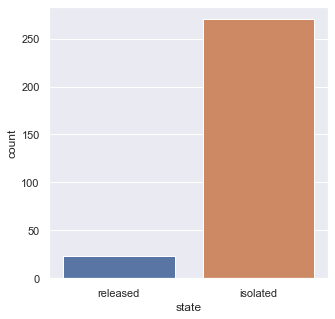

In [448]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=p_info['state'].loc[
    (p_info['infection_case']=='overseas inflow')
])

# Only 18 foreign patients here = Not many foreign patients in Korea

In [449]:
p_info['country'].value_counts()

Korea            2753
China              10
United States       3
Thailand            2
France              1
Mongolia            1
Switzerland         1
Name: country, dtype: int64

# Overseas inflow patients

In [450]:
inflow_p_info = p_info[p_info['infection_case'] == 'overseas inflow']

In [451]:
inflow_p_info['country'].value_counts()

Korea            282
China              5
United States      3
France             1
Thailand           1
Switzerland        1
Name: country, dtype: int64

# 1. foreign overseas inflow patients

# overseas inflow Chinese

In [452]:
china_inflow = p_info[p_info['country'] == 'China']
china_inflow = china_inflow[china_inflow['infection_case'] == 'overseas inflow']
china_inflow = china_inflow.reset_index(drop=True)
china_inflow

patient_id  global_num     sex  birth_year  age country     province  \
0  1000000011        23.0  female      1962.0  50s   China        Seoul   
1  1000000039       924.0  female      1945.0  70s   China        Seoul   
2  1400000001         1.0  female      1985.0  30s   China      Incheon   
3  2000000010        27.0  female      1982.0  30s   China  Gyeonggi-do   
4  3001000002         NaN    male         NaN  20s   China   Gangwon-do   

           city disease   infection_case  infection_order  infected_by  \
0  Seodaemun-gu     NaN  overseas inflow              1.0          NaN   
1  Geumcheon-gu     NaN  overseas inflow              NaN          NaN   
2           etc     NaN  overseas inflow              NaN          NaN   
3    Siheung-si     NaN  overseas inflow              1.0          NaN   
4  Gangneung-si     NaN  overseas inflow              NaN          NaN   

   contact_number symptom_onset_date confirmed_date released_date  \
0            23.0                NaN     2020-02-06    2020-02-29   
1             NaN                NaN     2020-02-25           NaN   
2             NaN         2020-01-19     2020-01-20    2020-02-06   
3            40.0                NaN     2020-02-09           NaN   
4             NaN                NaN     2020-03-01    2020-03-09   

  deceased_date     state  
0           NaN  released  
1           NaN  released  
2           NaN  released  
3           NaN  isolated  
4           NaN  released

In [453]:
infectedby = p_info[p_info['infected_by'].notna()]
infectedby.shape

(650, 18)

In [454]:
infectedby = infectedby.reset_index(drop=True)

# Patients infected by Chinese Inflow

In [455]:
infectedbyList = infectedby['infected_by'].isin(china_inflow['patient_id']).replace({False:np.nan}).dropna().index

# 5 -> 2

In [456]:
infectedbyChinese = pd.DataFrame(infectedby, index=infectedbyList)
infectedbyChinese

patient_id  global_num     sex  birth_year  age country     province  \
183  2000000008        25.0  female      1946.0  70s   Korea  Gyeonggi-do   
184  2000000009        26.0    male      1968.0  50s   Korea  Gyeonggi-do   

           city disease        infection_case  infection_order   infected_by  \
183  Siheung-si     NaN  contact with patient              2.0  2.000000e+09   
184  Siheung-si     NaN  contact with patient              1.0  2.000000e+09   

     contact_number symptom_onset_date confirmed_date released_date  \
183            12.0                NaN     2020-02-09    2020-03-05   
184             0.0                NaN     2020-02-09           NaN   

    deceased_date     state  
183           NaN  released  
184           NaN  isolated

In [457]:
infectedbyList2 = infectedby['infected_by'].isin(infectedbyChinese['patient_id']).replace({False:np.nan}).dropna().index

In [458]:
infectedbyChinese2 = pd.DataFrame(infectedby, index=infectedbyList2)
infectedbyChinese2

Empty DataFrame
Columns: [patient_id, global_num, sex, birth_year, age, country, province, city, disease, infection_case, infection_order, infected_by, contact_number, symptom_onset_date, confirmed_date, released_date, deceased_date, state]
Index: []

# The most overseas inflow chinese patients are released state.

# 2. overseas inflow US

In [459]:
US_inflow = p_info[p_info['country'] == 'United States']
US_inflow

patient_id  global_num     sex  birth_year  age        country province  \
334   1000000335      9085.0    male      1982.0  30s  United States    Seoul   
337   1000000338      9096.0  female      1998.0  20s  United States    Seoul   
2767  7000000006      9087.0    male         NaN  30s  United States  Jeju-do   

             city disease   infection_case  infection_order  infected_by  \
334    Gangseo-gu     NaN  overseas inflow              NaN          NaN   
337   Jungnang-gu     NaN  overseas inflow              NaN          NaN   
2767      Jeju-do     NaN  overseas inflow              NaN          NaN   

      contact_number symptom_onset_date confirmed_date released_date  \
334              NaN                NaN     2020-03-24           NaN   
337              NaN                NaN     2020-03-24           NaN   
2767            23.0                NaN     2020-03-24           NaN   

     deceased_date     state  
334            NaN  isolated  
337            NaN  isolated  
2767           NaN  isolated

In [460]:
infectedbyList = infectedby['infected_by'].isin(US_inflow['patient_id']).replace({False:np.nan}).dropna().index

In [461]:
infectedbyUS = pd.DataFrame(infectedby, index=infectedbyList)
infectedbyUS

Empty DataFrame
Columns: [patient_id, global_num, sex, birth_year, age, country, province, city, disease, infection_case, infection_order, infected_by, contact_number, symptom_onset_date, confirmed_date, released_date, deceased_date, state]
Index: []

# 3. overseas inflow France

In [462]:
france_inflow = p_info[p_info['country'] == 'France']
france_inflow

patient_id  global_num     sex  birth_year  age country province  \
376  1000000377      9338.0  female      1985.0  30s  France    Seoul   

          city disease   infection_case  infection_order  infected_by  \
376  Gwanak-gu     NaN  overseas inflow              NaN          NaN   

     contact_number symptom_onset_date confirmed_date released_date  \
376             NaN                NaN     2020-03-27           NaN   

    deceased_date     state  
376           NaN  isolated

In [463]:
infectedbyList = infectedby['infected_by'].isin(france_inflow['patient_id']).replace({False:np.nan}).dropna().index

In [464]:
infectedbyFrance = pd.DataFrame(infectedby, index=infectedbyList)
infectedbyFrance

Empty DataFrame
Columns: [patient_id, global_num, sex, birth_year, age, country, province, city, disease, infection_case, infection_order, infected_by, contact_number, symptom_onset_date, confirmed_date, released_date, deceased_date, state]
Index: []

# 4. overseas inflow Thailand

In [465]:
thailand_inflow = p_info[p_info['country'] == 'Thailand']
thailand_inflow

patient_id  global_num     sex  birth_year  age   country  \
378   1000000379      9368.0    male      1981.0  30s  Thailand   
2262  6006000017         NaN  female      1993.0  20s  Thailand   

              province          city disease   infection_case  \
378              Seoul  Seodaemun-gu     NaN  overseas inflow   
2262  Gyeongsangbuk-do   Gimcheon-si     NaN              NaN   

      infection_order  infected_by  contact_number symptom_onset_date  \
378               NaN          NaN             NaN                NaN   
2262              NaN          NaN             NaN                NaN   

     confirmed_date released_date deceased_date     state  
378      2020-03-27           NaN           NaN  isolated  
2262     2020-03-05           NaN           NaN  isolated

In [466]:
infectedbyList = infectedby['infected_by'].isin(thailand_inflow['patient_id']).replace({False:np.nan}).dropna().index

In [467]:
infectedbyThailand = pd.DataFrame(infectedby, index=infectedbyList)
infectedbyThailand

Empty DataFrame
Columns: [patient_id, global_num, sex, birth_year, age, country, province, city, disease, infection_case, infection_order, infected_by, contact_number, symptom_onset_date, confirmed_date, released_date, deceased_date, state]
Index: []

# 5. overseas inflow Switz

In [468]:
switz_inflow = p_info[p_info['country'] == 'Switzerland']
switz_inflow

patient_id  global_num   sex  birth_year  age      country province  \
537  1100000104         NaN  male      1996.0  20s  Switzerland    Busan   

           city disease   infection_case  infection_order  infected_by  \
537  Dongnae-gu     NaN  overseas inflow              NaN          NaN   

     contact_number symptom_onset_date confirmed_date released_date  \
537             5.0         2020-03-17     2020-03-18           NaN   

    deceased_date     state  
537           NaN  isolated

In [469]:
infectedbyList = infectedby['infected_by'].isin(switz_inflow['patient_id']).replace({False:np.nan}).dropna().index

In [470]:
infectedbySwitz = pd.DataFrame(infectedby, index=infectedbyList)
infectedbySwitz

Empty DataFrame
Columns: [patient_id, global_num, sex, birth_year, age, country, province, city, disease, infection_case, infection_order, infected_by, contact_number, symptom_onset_date, confirmed_date, released_date, deceased_date, state]
Index: []

# 6. overseas inflow Mongolia

In [471]:
mongolia_inflow = p_info[p_info['country'] == 'Mongolia']
mongolia_inflow

patient_id  global_num   sex  birth_year  age   country     province  \
851  2000000039       875.0  male      1984.0  30s  Mongolia  Gyeonggi-do   

             city disease infection_case  infection_order  infected_by  \
851  Namyangju-si    True            etc              NaN          NaN   

     contact_number symptom_onset_date confirmed_date released_date  \
851             NaN                NaN     2020-02-25           NaN   

    deceased_date     state  
851    2020-02-25  deceased

In [472]:
infectedbyList = infectedby['infected_by'].isin(mongolia_inflow['patient_id']).replace({False:np.nan}).dropna().index

In [473]:
infectedbyMongolia = pd.DataFrame(infectedby, index=infectedbyList)
infectedbyMongolia

Empty DataFrame
Columns: [patient_id, global_num, sex, birth_year, age, country, province, city, disease, infection_case, infection_order, infected_by, contact_number, symptom_onset_date, confirmed_date, released_date, deceased_date, state]
Index: []

#  = No critical affects from foreign overseas inflow patients
# The most overseas inflow patients are Korean patients living in foreign countries.

# 2. Koreans overseas inflow to Korea

In [474]:
koreanPatient = p_info[p_info['country'] == 'Korea']

In [475]:
koreanPatient['infection_case'].value_counts()

contact with patient                     740
etc                                      351
overseas inflow                          282
Guro-gu Call Center                      112
Shincheonji Church                       102
Onchun Church                             33
Bonghwa Pureun Nursing Home               31
gym facility in Cheonan                   30
Ministry of Oceans and Fisheries          28
Cheongdo Daenam Hospital                  21
Dongan Church                             17
Eunpyeong St. Mary's Hospital             13
Seongdong-gu APT                          13
Gyeongsan Jeil Silver Town                12
Gyeongsan Seorin Nursing Home             11
Gyeongsan Cham Joeun Community Center     10
Geochang Church                            6
gym facility in Sejong                     4
Changnyeong Coin Karaoke                   4
Suyeong-gu Kindergarten                    3
Pilgrimage to Israel                       2
River of Grace Community Church            1
Name: infe

In [476]:
koreanPatient['infection_case'].value_counts().sum()

1826

# Korean brought virus from overseas to Korea

In [477]:
foreignVisit = ['overseas inflow', 'Pilgrimage to Israel']

In [478]:
korea_inflow = koreanPatient.loc[koreanPatient['infection_case'].isin(foreignVisit)]

In [479]:
korea_inflow.shape[0]

284

In [480]:
korea_inflow.head()

patient_id  global_num   sex  birth_year  age country province  \
0  1000000001         2.0  male      1964.0  50s   Korea    Seoul   
1  1000000002         5.0  male      1987.0  30s   Korea    Seoul   
3  1000000004         7.0  male      1991.0  20s   Korea    Seoul   
7  1000000008        13.0  male      1992.0  20s   Korea    Seoul   
8  1000000009        19.0  male      1983.0  30s   Korea    Seoul   

          city disease   infection_case  infection_order  infected_by  \
0   Gangseo-gu     NaN  overseas inflow              1.0          NaN   
1  Jungnang-gu     NaN  overseas inflow              1.0          NaN   
3      Mapo-gu     NaN  overseas inflow              1.0          NaN   
7          etc     NaN  overseas inflow              1.0          NaN   
8    Songpa-gu     NaN  overseas inflow              2.0          NaN   

   contact_number symptom_onset_date confirmed_date released_date  \
0            75.0         2020-01-22     2020-01-23    2020-02-05   
1            31.0                NaN     2020-01-30    2020-03-02   
3             9.0         2020-01-26     2020-01-30    2020-02-15   
7             0.0                NaN     2020-02-02    2020-02-24   
8            68.0                NaN     2020-02-05    2020-02-21   

  deceased_date     state  
0           NaN  released  
1           NaN  released  
3           NaN  released  
7           NaN  released  
8           NaN  released

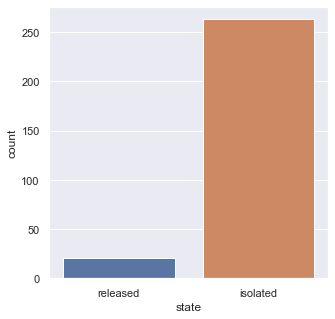

In [481]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=korea_inflow['state'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text yticklabel objects>)

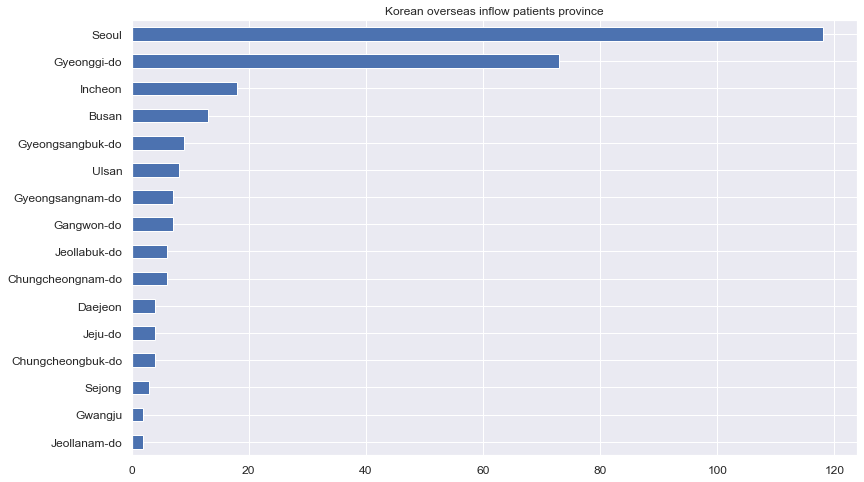

In [482]:
plt.figure(figsize=(13, 8))
plt.title('Korean overseas inflow patients province')
korea_inflow.province.value_counts(ascending=True).plot.barh()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text yticklabel objects>)

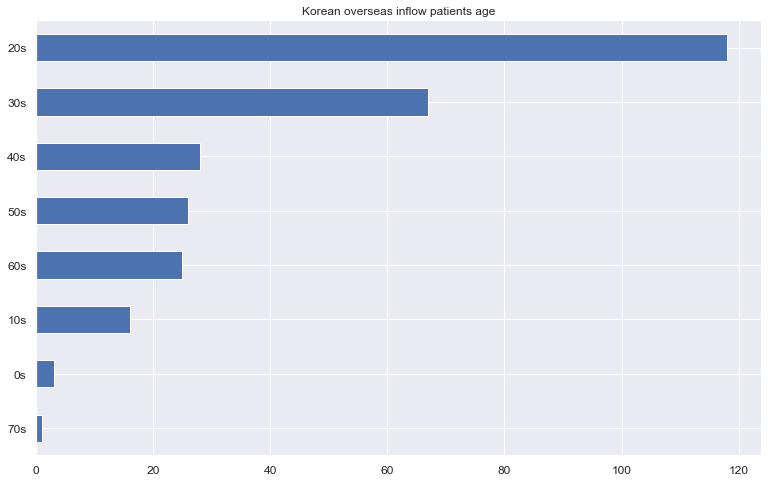

In [483]:
plt.figure(figsize=(13, 8))
plt.title('Korean overseas inflow patients age')
korea_inflow.age.value_counts(ascending=True).plot.barh()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

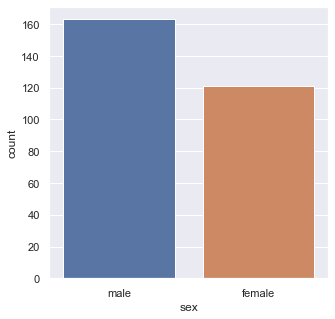

In [484]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=korea_inflow['sex'])

# Patients infected by Korean overseas inflow patients

In [485]:
infectedbyList = infectedby['infected_by'].isin(korea_inflow['patient_id']).replace({False:np.nan}).dropna().index

# 284 -> 52

In [486]:
infectedbyKorean = pd.DataFrame(infectedby, index=infectedbyList)
infectedbyKorean.shape[0]

52

In [487]:
infectedbyKorean.head()

patient_id  global_num     sex  birth_year  age country province  \
1   1000000005         9.0  female      1992.0  20s   Korea    Seoul   
31  1000000117      6999.0    male      1955.0  60s   Korea    Seoul   
46  1000000191      7647.0  female      1990.0  30s   Korea    Seoul   
50  1000000232      8074.0    male      1998.0  20s   Korea    Seoul   
51  1000000233      8127.0  female      1991.0  20s   Korea    Seoul   

            city disease        infection_case  infection_order   infected_by  \
1    Seongbuk-gu     NaN  contact with patient              2.0  1.000000e+09   
31     Seocho-gu     NaN  contact with patient              NaN  1.000000e+09   
46  Eunpyeong-gu     NaN       overseas inflow              NaN  1.000000e+09   
50     Gwanak-gu     NaN  contact with patient              NaN  1.000000e+09   
51     Seocho-gu     NaN  contact with patient              NaN  1.000000e+09   

    contact_number symptom_onset_date confirmed_date released_date  \
1              2.0                NaN     2020-01-31    2020-02-24   
31             NaN         2020-03-06     2020-03-07           NaN   
46             NaN                NaN     2020-03-10           NaN   
50             NaN                NaN     2020-03-13           NaN   
51             NaN                NaN     2020-03-13           NaN   

   deceased_date     state  
1            NaN  released  
31           NaN  isolated  
46           NaN  isolated  
50           NaN  isolated  
51           NaN  isolated

In [488]:
infectedbyList2 = infectedby['infected_by'].isin(infectedbyKorean['patient_id']).replace({False:np.nan}).dropna().index

# 284 -> 52 -> 1

In [489]:
infectedbyKorean2 = pd.DataFrame(infectedby, index=infectedbyList2)
infectedbyKorean2

patient_id  global_num     sex  birth_year  age country  \
182  2000000007        20.0  female      1978.0  40s   Korea   
550  4100000116         NaN    male      1955.0  60s   Korea   
551  4100000118         NaN  female      1958.0  60s   Korea   

              province           city disease        infection_case  \
182        Gyeonggi-do       Suwon-si     NaN  contact with patient   
550  Chungcheongnam-do  Hongseong-gun     NaN       overseas inflow   
551  Chungcheongnam-do  Hongseong-gun     NaN       overseas inflow   

     infection_order   infected_by  contact_number symptom_onset_date  \
182              3.0  2.000000e+09             2.0         2020-02-04   
550              NaN  4.100000e+09             0.0         2020-03-16   
551              NaN  4.100000e+09             5.0                NaN   

    confirmed_date released_date deceased_date     state  
182     2020-02-05    2020-02-24           NaN  released  
550     2020-03-17           NaN           NaN  isolated  
551     2020-03-17           NaN           NaN  isolated

In [490]:
infectedbyList3 = infectedby['infected_by'].isin(infectedbyKorean2['patient_id']).replace({False:np.nan}).dropna().index

# 284 -> 52 -> 1 -> 1

In [491]:
infectedbyKorean3 = pd.DataFrame(infectedby, index=infectedbyList3)
infectedbyKorean3

patient_id  global_num     sex  birth_year  age country  \
186  2000000012        32.0  female      2009.0  10s   Korea   
550  4100000116         NaN    male      1955.0  60s   Korea   
551  4100000118         NaN  female      1958.0  60s   Korea   

              province           city disease        infection_case  \
186        Gyeonggi-do       Suwon-si     NaN  contact with patient   
550  Chungcheongnam-do  Hongseong-gun     NaN       overseas inflow   
551  Chungcheongnam-do  Hongseong-gun     NaN       overseas inflow   

     infection_order   infected_by  contact_number symptom_onset_date  \
186              NaN  2.000000e+09             NaN                NaN   
550              NaN  4.100000e+09             0.0         2020-03-16   
551              NaN  4.100000e+09             5.0                NaN   

    confirmed_date released_date deceased_date     state  
186     2020-02-18    2020-03-04           NaN  released  
550     2020-03-17           NaN           NaN  isolated  
551     2020-03-17           NaN           NaN  isolated

# Total 54 patients are infected by Korean overseas inflow patients, and it might be more than this.
# We can assume that Korean overseas inflow patients are far more than foreign patients, and they affect more than foreign inflow patients.

# It can be overfitting, but we can assume some facts from the data.

# 1. The most foreign overseas inflow patients have no critical affects to patients until now. (No big group infection or many contacts)
# 2. Rather Koreans overseas inflow have more affects.(No big group infection either but the number is far more than it of foreign overseas inflow)

# This is the reason that the Korean government does not commit the prohibition of entry of foreign people. If it were effective, it must be a border closure for all people. But it seems like unrealistic.

# B. Case infection

In [492]:
case.head()

case_id province           city  group                 infection_case  \
0  1000001    Seoul        Guro-gu   True            Guro-gu Call Center   
1  1000002    Seoul  Dongdaemun-gu   True                  Dongan Church   
2  1000003    Seoul        Guro-gu   True          Manmin Central Church   
3  1000004    Seoul   Eunpyeong-gu   True  Eunpyeong St. Mary's Hospital   
4  1000005    Seoul   Seongdong-gu   True               Seongdong-gu APT   

   confirmed   latitude   longitude  
0         96  37.508163  126.884387  
1         20  37.592888  127.056766  
2         20  37.481059  126.894343  
3         14   37.63369    126.9165  
4         13   37.55713    127.0403

# Daegu and GSBD has the most many patients among provinces.

In [493]:
provinceList = case['province'].unique()
columns = ['total_confirmed']
provinceTotal = pd.DataFrame(index = provinceList, columns = columns)
for i in range(len(provinceList)):
    provinceTotal.loc[provinceList[i]] = case[case['province'] == provinceList[i]]['confirmed'].sum()
provinceTotal = provinceTotal.sort_values(by=['total_confirmed'], ascending=True)

In [494]:
case['confirmed'].sum()

8531

In [495]:
provinceTotal.tail()

total_confirmed
Chungcheongnam-do              126
Gyeonggi-do                    355
Seoul                          360
Gyeongsangbuk-do              1066
Daegu                         6135

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text yticklabel objects>)

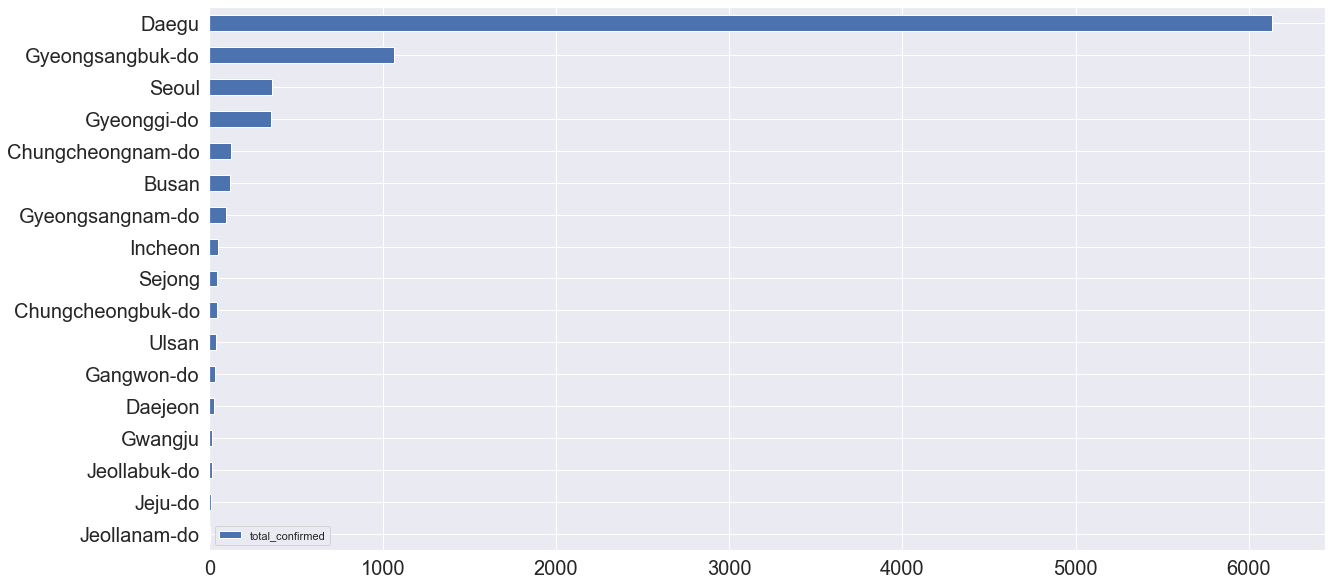

In [496]:
dataFrame = pd.DataFrame(data=provinceTotal, index=provinceTotal.index);
dataFrame.plot.barh(figsize=(20,10));
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [497]:
cityList = case['city'].unique()
columns = ['total_confirmed']
cityTotal = pd.DataFrame(index = cityList, columns = columns)
for i in range(len(cityList)):
    cityTotal.loc[cityList[i]] = case[case['city'] == cityList[i]]['confirmed'].sum()
cityTotal = cityTotal.sort_values(by=['total_confirmed'], ascending=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 <a list of 28 Text yticklabel objects>)

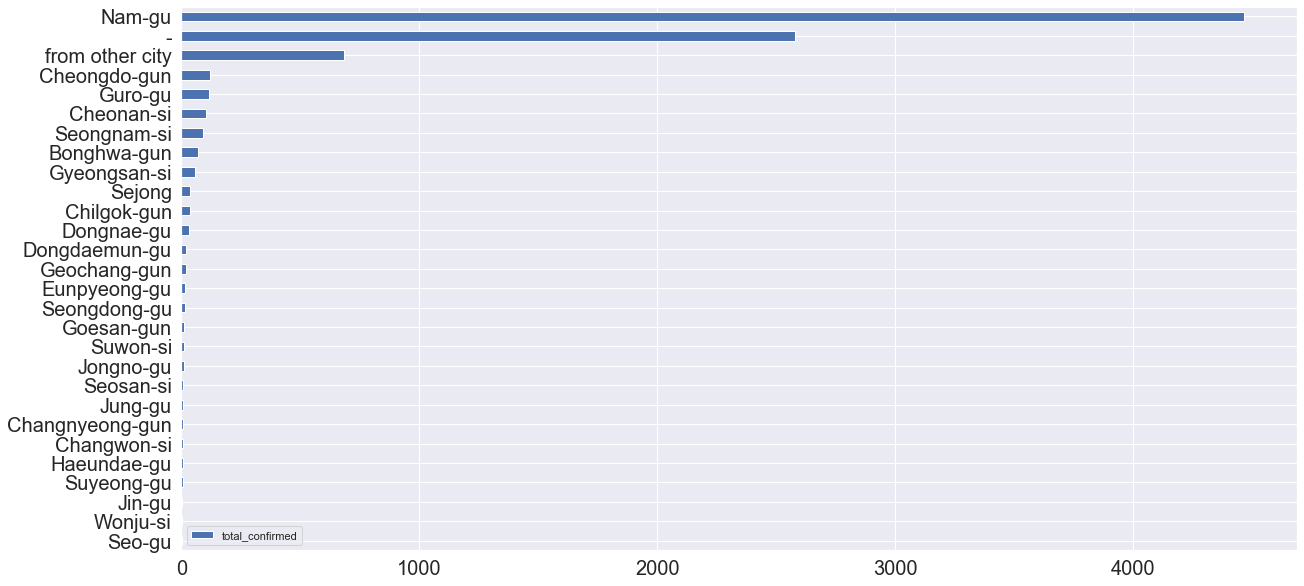

In [498]:
dataFrame = pd.DataFrame(data=cityTotal, index=cityTotal.index);
dataFrame.plot.barh(figsize=(20,10));
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Let's see the total confirmed number of each cases

In [499]:
caseList = case['infection_case'].unique()
columns = ['total_confirmed']
caseTotal = pd.DataFrame(index = caseList, columns = columns)
for i in range(len(caseList)):
    caseTotal.loc[caseList[i]] = case[case['infection_case'] == caseList[i]]['confirmed'].sum()
caseTotal = caseTotal.sort_values(by=['total_confirmed'], ascending=True)

In [500]:
caseTotal.tail()

total_confirmed
Guro-gu Call Center               164
overseas inflow                   274
etc                              1062
contact with patient             1258
Shincheonji Church               5009

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]), <a list of 36 Text yticklabel objects>)

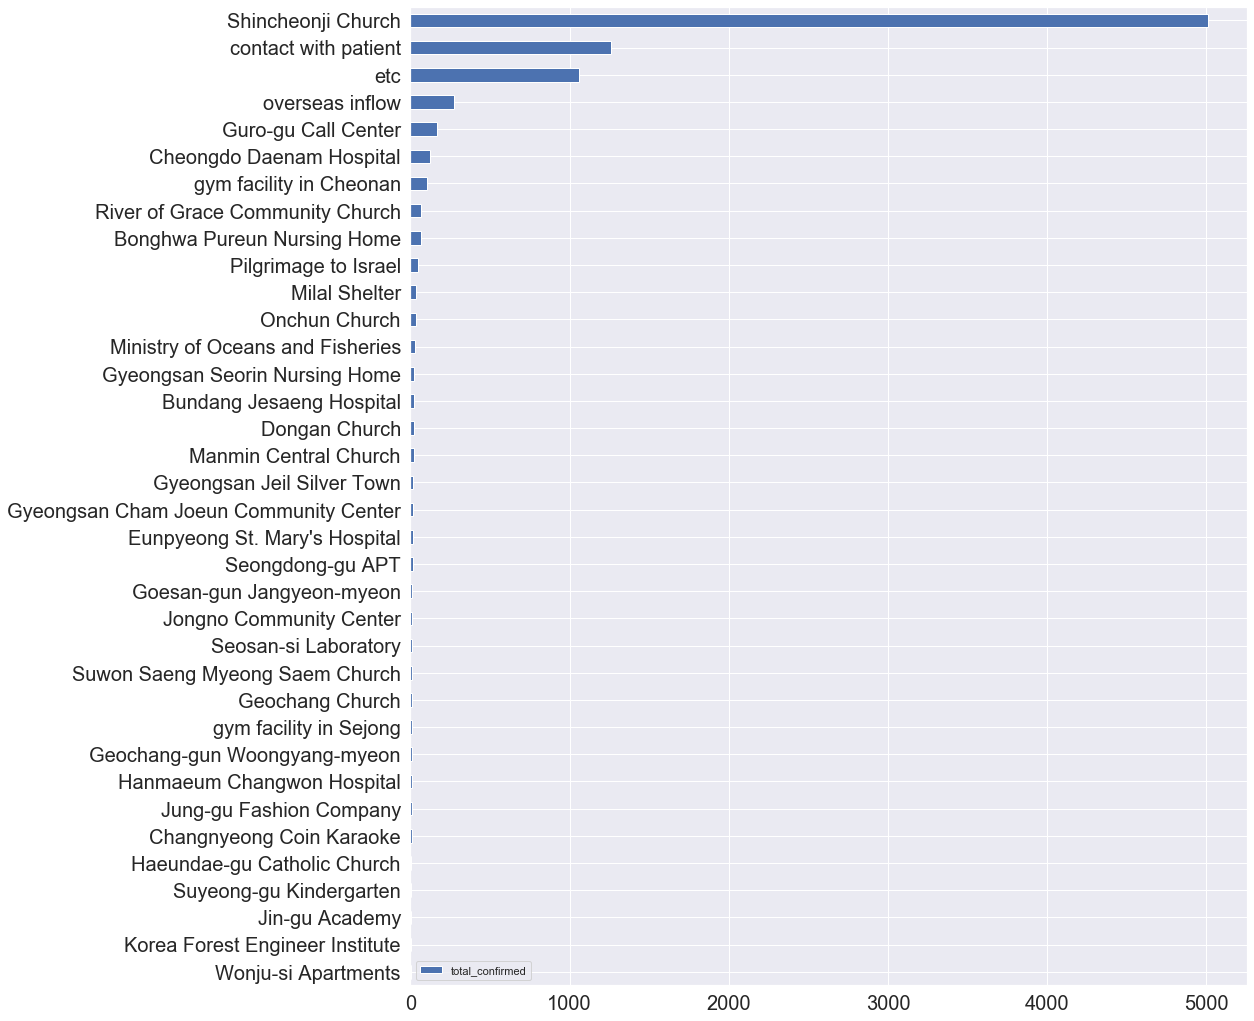

In [501]:
dataFrame = pd.DataFrame(data=caseTotal, index=caseTotal.index);
dataFrame.plot.barh(figsize=(15,18));
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# 1. Shincheonji Church
# over 60% patients are infected from SCJ Church group infection.
# over 80% patients are from Daegu and Gyeongsangbuk-do.
# Daegu is the heart of SCJ Church, and Gyeongsangbuk-do is very close to Daegu, so more than 80% patients are affected by the SCJ church.

# 2. Overseas inflow
# patient info(p_info) tells us that the substantial number of patients are infected by Korean overseas inflow.
# Also, there is the news about 50 Korean members of SCJ Church visited to Wuhan.
# https://n.news.naver.com/article/277/0004634085

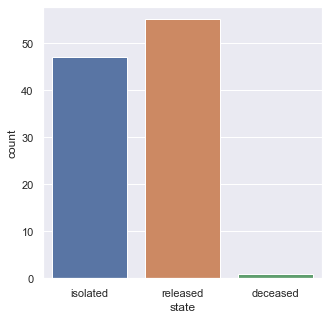

In [502]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=p_info['state'].loc[
    (p_info['infection_case']=='Shincheonji Church')
])

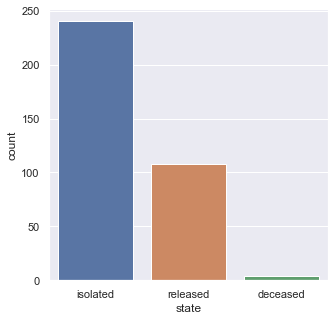

In [503]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=p_info['state'].loc[
    (p_info['infection_case']=='etc')
])

# Let's see whether group infection or not

In [504]:
columns = ['group']
caseGroup = pd.DataFrame(index = caseList, columns = columns)
for i in range(len(caseList)):
    caseGroup.loc[caseList[i]] = case[case['infection_case'] == caseList[i]]['group'].values[0]

In [505]:
caseGroup

group
Guro-gu Call Center                     True
Dongan Church                           True
Manmin Central Church                   True
Eunpyeong St. Mary's Hospital           True
Seongdong-gu APT                        True
Jongno Community Center                 True
Jung-gu Fashion Company                 True
Shincheonji Church                      True
overseas inflow                        False
contact with patient                   False
etc                                    False
Onchun Church                           True
Suyeong-gu Kindergarten                 True
Haeundae-gu Catholic Church             True
Jin-gu Academy                          True
Cheongdo Daenam Hospital                True
Korea Forest Engineer Institute         True
Seosan-si Laboratory                    True
Ministry of Oceans and Fisheries        True
gym facility in Sejong                  True
Bundang Jesaeng Hospital                True
River of Grace Community Church         True
Suwon Saeng Myeong Saem Church          True
Wonju-si Apartments                     True
Goesan-gun Jangyeon-myeon               True
gym facility in Cheonan                 True
Bonghwa Pureun Nursing Home             True
Pilgrimage to Israel                    True
Milal Shelter                           True
Gyeongsan Seorin Nursing Home           True
Gyeongsan Jeil Silver Town              True
Gyeongsan Cham Joeun Community Center   True
Geochang Church                         True
Geochang-gun Woongyang-myeon            True
Hanmaeum Changwon Hospital              True
Changnyeong Coin Karaoke                True

# Group infection vs. Not group infection

In [506]:
caseAnalysis = pd.concat([caseTotal, caseGroup], axis=1, sort=False)
caseAnalysis.sort_values(by=['total_confirmed'], ascending=False)

total_confirmed  group
Shincheonji Church                                5009   True
contact with patient                              1258  False
etc                                               1062  False
overseas inflow                                    274  False
Guro-gu Call Center                                164   True
Cheongdo Daenam Hospital                           123   True
gym facility in Cheonan                            103   True
Bonghwa Pureun Nursing Home                         68   True
River of Grace Community Church                     68   True
Pilgrimage to Israel                                49   True
Milal Shelter                                       36   True
Onchun Church                                       34   True
Ministry of Oceans and Fisheries                    30   True
Gyeongsan Seorin Nursing Home                       22   True
Bundang Jesaeng Hospital                            22   True
Manmin Central Church                               20   True
Dongan Church                                       20   True
Gyeongsan Jeil Silver Town                          17   True
Gyeongsan Cham Joeun Community Center               16   True
Eunpyeong St. Mary's Hospital                       14   True
Seongdong-gu APT                                    13   True
Goesan-gun Jangyeon-myeon                           11   True
Jongno Community Center                             10   True
Seosan-si Laboratory                                10   True
Suwon Saeng Myeong Saem Church                      10   True
Geochang Church                                     10   True
gym facility in Sejong                               8   True
Geochang-gun Woongyang-myeon                         8   True
Hanmaeum Changwon Hospital                           7   True
Jung-gu Fashion Company                              7   True
Changnyeong Coin Karaoke                             7   True
Haeundae-gu Catholic Church                          6   True
Suyeong-gu Kindergarten                              5   True
Jin-gu Academy                                       4   True
Korea Forest Engineer Institute                      3   True
Wonju-si Apartments                                  3   True

In [507]:
caseAnalysis['total_confirmed'].sum()

8531

In [508]:
caseGroup = caseAnalysis[caseAnalysis['group'] == True]['total_confirmed'].sum()

In [509]:
caseNotGroup = caseAnalysis[caseAnalysis['group'] == False]['total_confirmed'].sum()

In [510]:
index = ['group', 'not group']
column = ['total_confirmed']
df = pd.DataFrame(index=index, columns=column)
df.loc['group']['total_confirmed'] = caseGroup
df.loc['not group']['total_confirmed'] = caseNotGroup
df

total_confirmed
group                5937
not group            2594

Text(0.5, 1.0, 'Group vs. Non-group')

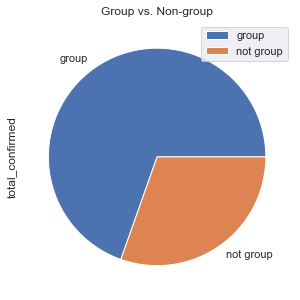

In [511]:
plot = df.plot.pie(y='total_confirmed', figsize=(5, 5))
plt.title("Group vs. Non-group")

# Over 70% patients are group infection
# The most part of the rest patients might be infections from family or friends, which is not counted as group infection.

In [512]:
cityTotal['city'] = cityTotal.index
cityTotal = cityTotal.reset_index(drop=True)
cityTotal = cityTotal.sort_values(by=['total_confirmed'], ascending=False)

In [513]:
cityTotal.shape

(28, 2)

In [514]:
caseTemp = case.loc[:, ['city', 'latitude', 'longitude']]
clus = cityTotal.merge(caseTemp, on='city')
clus = clus.sort_values(by=['total_confirmed'], ascending=False)
clus = clus.drop(clus[clus['latitude'] == '-'].index)
clus = clus.drop_duplicates('city')
clus = clus.reset_index(drop=True)
clus.shape

(25, 4)

In [515]:
clus

total_confirmed             city   latitude   longitude
0              4467           Nam-gu   35.84008    128.5667
1               120     Cheongdo-gun   35.64887    128.7368
2               116          Guro-gu  37.508163  126.884387
3               103       Cheonan-si   36.81503    127.1139
4                90      Seongnam-si   37.38833    127.1218
5                68      Bonghwa-gun   36.92757    128.9099
6                55     Gyeongsan-si  35.782149  128.801498
7                38           Sejong   36.48025     127.289
8                36      Chilgok-gun    36.0581    128.4941
9                32       Dongnae-gu   35.21628    129.0771
10               20    Dongdaemun-gu  37.592888  127.056766
11               18     Geochang-gun   35.68556    127.9127
12               14     Eunpyeong-gu   37.63369    126.9165
13               13     Seongdong-gu   37.55713    127.0403
14               11       Goesan-gun   36.82422    127.9552
15               10        Jongno-gu   37.57681     127.006
16               10         Suwon-si    37.2376    127.0517
17                8        Seosan-si  37.000354  126.354443
18                7          Jung-gu  37.562405  126.984377
19                7  Changnyeong-gun   35.54127    128.5008
20                7      Changwon-si   35.22115    128.6866
21                6      Haeundae-gu   35.20599    129.1256
22                5       Suyeong-gu   35.16708    129.1124
23                4           Jin-gu   35.17371    129.0633
24                3           Seo-gu  36.358123  127.388856

In [516]:
clus['longitude'] = pd.to_numeric(clus['longitude'])
clus['latitude'] = pd.to_numeric(clus['latitude'])

In [517]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(clus['longitude'], clus['latitude'])]
geometry[1:3]

In [518]:
import geopandas as gpd
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(clus, crs=crs, geometry=geometry)
geo_df

/Users/parkchanjin/PycharmProjects/ml-work/venv/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



total_confirmed             city   latitude   longitude  \
0              4467           Nam-gu  35.840080  128.566700   
1               120     Cheongdo-gun  35.648870  128.736800   
2               116          Guro-gu  37.508163  126.884387   
3               103       Cheonan-si  36.815030  127.113900   
4                90      Seongnam-si  37.388330  127.121800   
5                68      Bonghwa-gun  36.927570  128.909900   
6                55     Gyeongsan-si  35.782149  128.801498   
7                38           Sejong  36.480250  127.289000   
8                36      Chilgok-gun  36.058100  128.494100   
9                32       Dongnae-gu  35.216280  129.077100   
10               20    Dongdaemun-gu  37.592888  127.056766   
11               18     Geochang-gun  35.685560  127.912700   
12               14     Eunpyeong-gu  37.633690  126.916500   
13               13     Seongdong-gu  37.557130  127.040300   
14               11       Goesan-gun  36.824220  127.955200   
15               10        Jongno-gu  37.576810  127.006000   
16               10         Suwon-si  37.237600  127.051700   
17                8        Seosan-si  37.000354  126.354443   
18                7          Jung-gu  37.562405  126.984377   
19                7  Changnyeong-gun  35.541270  128.500800   
20                7      Changwon-si  35.221150  128.686600   
21                6      Haeundae-gu  35.205990  129.125600   
22                5       Suyeong-gu  35.167080  129.112400   
23                4           Jin-gu  35.173710  129.063300   
24                3           Seo-gu  36.358123  127.388856   

                      geometry  
0   POINT (128.56670 35.84008)  
1   POINT (128.73680 35.64887)  
2   POINT (126.88439 37.50816)  
3   POINT (127.11390 36.81503)  
4   POINT (127.12180 37.38833)  
5   POINT (128.90990 36.92757)  
6   POINT (128.80150 35.78215)  
7   POINT (127.28900 36.48025)  
8   POINT (128.49410 36.05810)  
9   POINT (129.07710 35.21628)  
10  POINT (127.05677 37.59289)  
11  POINT (127.91270 35.68556)  
12  POINT (126.91650 37.63369)  
13  POINT (127.04030 37.55713)  
14  POINT (127.95520 36.82422)  
15  POINT (127.00600 37.57681)  
16  POINT (127.05170 37.23760)  
17  POINT (126.35444 37.00035)  
18  POINT (126.98438 37.56240)  
19  POINT (128.50080 35.54127)  
20  POINT (128.68660 35.22115)  
21  POINT (129.12560 35.20599)  
22  POINT (129.11240 35.16708)  
23  POINT (129.06330 35.17371)  
24  POINT (127.38886 36.35812)

# The bigger radius the bigger total confirmed number

In [519]:
import folium
southkorea_map = folium.Map(location=[36.55,126.983333 ], zoom_start=7,tiles='Stamen Toner')

for lat, lon, city, total in zip(geo_df['latitude'], geo_df['longitude'], geo_df['city'], geo_df['total_confirmed']):
    folium.CircleMarker([lat, lon],
                        radius=int(total/100),
                        color='red',
                      popup =('City: ' + str(city) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(southkorea_map)
southkorea_map

# over 60% patients are infected in SCJ Church by group infection.
# over 80% patients are from Daegu and Gyeongsangbuk-do.
# especially Daegu is the heart of SCJ Church, and Gyeongsangbuk-do is very close to Daegu, so the most infected patients come from Daegu and GSBD.

The number of cases from Daegu and Gyeongbuk accounts for over 80 percent of the total infections. This is closely related to a religious group called Shincheonji Church of Jesus based in Daegu, where a collective infection has occurred and is spreading throughout the country. About 60 percent of all infections in South Korea were related to Shincheonji. 
Over 70 percent is group infection, and about 15 percent is contact with family-friend patients.

# C. Patients' routes

China inflow patients are the only overseas inflow patients data here.

In [520]:
p_route.head()

patient_id  global_num        date province         city      type  \
0  1000000002         5.0  2020-01-26    Seoul  Gwangjin-gu     store   
1  1000000002         5.0  2020-01-27    Seoul   Gangbuk-gu     store   
2  1000000002         5.0  2020-01-28    Seoul   Gangbuk-gu     store   
3  1000000002         5.0  2020-01-29    Seoul  Seongbuk-gu  hospital   
4  1000000002         5.0  2020-01-30    Seoul  Seongbuk-gu  hospital   

    latitude   longitude  
0  37.563992  127.029534  
1  37.592057  127.018898  
2  37.591669  127.018420  
3  37.606498  127.092761  
4  37.612772  127.098167

In [521]:
chinaInflowList = p_route['patient_id'].isin(china_inflow['patient_id']).replace({False:np.nan}).dropna().index

In [522]:
koreaInflowList = p_route['patient_id'].isin(korea_inflow['patient_id']).replace({False:np.nan}).dropna().index

In [523]:
china_inflow_route = pd.DataFrame(p_route, index=chinaInflowList)
china_inflow_route

patient_id  global_num        date     province          city      type  \
17   1000000011        23.0  2020-02-02        Seoul       Jung-gu     store   
18   1000000011        23.0  2020-02-06        Seoul       Jung-gu  hospital   
120  1000000039       907.0  2020-02-20  Gyeonggi-do  Pyungtaek-si  pharmacy   
121  1000000039       907.0  2020-02-21        Seoul   Gangdong-gu  hospital   
122  1000000039       907.0  2020-02-21  Gyeonggi-do  Pyungtaek-si  hospital   
123  1000000039       907.0  2020-02-24        Seoul   Gangdong-gu  hospital   
124  1000000039       907.0  2020-02-25  Gyeonggi-do       Paju-si  hospital   

      latitude   longitude  
17   37.568369  126.977790  
18   37.567241  127.005659  
120  36.992108  127.112945  
121  37.496318  127.123435  
122  37.083012  127.056559  
123  37.496318  127.123435  
124  37.754825  126.779723

In [524]:
korea_inflow_route = pd.DataFrame(p_route, index=koreaInflowList)
korea_inflow_route.head()

patient_id  global_num        date province         city      type  \
0  1000000002         5.0  2020-01-26    Seoul  Gwangjin-gu     store   
1  1000000002         5.0  2020-01-27    Seoul   Gangbuk-gu     store   
2  1000000002         5.0  2020-01-28    Seoul   Gangbuk-gu     store   
3  1000000002         5.0  2020-01-29    Seoul  Seongbuk-gu  hospital   
4  1000000002         5.0  2020-01-30    Seoul  Seongbuk-gu  hospital   

    latitude   longitude  
0  37.563992  127.029534  
1  37.592057  127.018898  
2  37.591669  127.018420  
3  37.606498  127.092761  
4  37.612772  127.098167

In [525]:
p_info['infection_case'].unique()

array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Gyeongsan Seorin Nursing Home',
       'Gyeongsan Cham Joeun Community Center',
       'Gyeongsan Jeil Silver Town', 'Bonghwa Pureun Nursing Home',
       'Pilgrimage to Israel', 'Geochang Church',
       'Changnyeong Coin Karaoke'], dtype=object)

In [526]:
SCJChurchList = p_route['patient_id'].isin(p_info[p_info['infection_case'] == 'Shincheonji Church']['patient_id']).replace({False:np.nan}).dropna().index
SCJChurch_route = pd.DataFrame(p_route, index=SCJChurchList)
SCJChurch_route

patient_id  global_num        date           province           city  \
56    1000000023       188.0  2020-02-12              Daegu         Nam-gu   
57    1000000023       188.0  2020-02-14              Seoul     Gangnam-gu   
58    1000000023       188.0  2020-02-16        Gyeonggi-do     Gwachun-si   
59    1000000023       188.0  2020-02-20              Seoul     Gangnam-gu   
156   1000000047      1247.0  2020-02-16              Daegu        Jung-gu   
157   1000000047      1247.0  2020-02-19              Seoul      Songpa-gu   
158   1000000047      1247.0  2020-02-20              Seoul     Gangnam-gu   
159   1000000047      1247.0  2020-02-20              Seoul      Songpa-gu   
160   1000000047      1247.0  2020-02-20              Seoul    Gwangjin-gu   
161   1000000047      1247.0  2020-02-20              Seoul        Jung-gu   
162   1000000047      1247.0  2020-02-21              Seoul        Jung-gu   
163   1000000047      1247.0  2020-02-21              Seoul    Gwangjin-gu   
164   1000000047      1247.0  2020-02-21              Seoul      Songpa-gu   
165   1000000047      1247.0  2020-02-24              Daegu        Jung-gu   
166   1000000047      1247.0  2020-02-25              Seoul      Songpa-gu   
167   1000000047      1247.0  2020-02-26              Seoul     Gangseo-gu   
1293  1000000231      8055.0  2020-02-16        Gyeonggi-do     Gwachun-si   
1294  1000000231      8055.0  2020-02-22              Seoul     Gangnam-gu   
1295  1000000231      8055.0  2020-02-22              Seoul     Gangnam-gu   
1296  1000000231      8055.0  2020-02-27  Chungcheongbuk-do  Youngdong-gun   
1297  1000000231      8055.0  2020-02-28              Seoul     Gangnam-gu   
1298  1000000231      8055.0  2020-03-01              Seoul     Gangnam-gu   
1299  1000000231      8055.0  2020-03-02              Seoul     Gangnam-gu   
1300  1000000231      8055.0  2020-03-04  Chungcheongbuk-do  Youngdong-gun   
1301  1000000231      8055.0  2020-03-05              Seoul     Gangnam-gu   
1302  1000000231      8055.0  2020-03-06              Seoul     Gangnam-gu   
1303  1000000231      8055.0  2020-03-07  Chungcheongbuk-do  Youngdong-gun   
1304  1000000231      8055.0  2020-03-08              Seoul     Gangnam-gu   
1305  1000000231      8055.0  2020-03-09              Seoul     Gangnam-gu   
1306  1000000231      8055.0  2020-03-11              Seoul     Gangnam-gu   
1307  1000000231      8055.0  2020-03-11              Seoul     Gangnam-gu   
1308  1000000231      8055.0  2020-03-12              Seoul     Gangnam-gu   

                       type   latitude   longitude  
56                   church  35.841206  128.598243  
57                      etc  37.477840  126.987315  
58                   church  37.435023  126.991583  
59                      etc  37.488337  127.028614  
156                  church  35.871435  128.601445  
157       government_office  37.513530  127.031534  
158              restaurant  37.486472  127.012918  
159   public_transportation  37.510275  127.043817  
160   public_transportation  37.561128  127.035505  
161   public_transportation  37.567014  126.997830  
162   public_transportation  37.567014  126.997830  
163   public_transportation  37.561128  127.035505  
164   public_transportation  37.510275  127.043817  
165                hospital  35.871435  128.601445  
166                hospital  37.516258  127.042214  
167                hospital  37.511972  126.833222  
1293                    etc  37.429246  126.987445  
1294               hospital  37.469095  127.040023  
1295                  store  37.470798  127.043494  
1296                  store  36.172753  127.773717  
1297                  store  37.456535  127.059406  
1298                  store  37.462077  127.046382  
1299                  store  37.462993  127.043105  
1300                  store  36.172753  127.773717  
1301                  store  37.462993  127.043105  
1302                 bakery  37.476366  127.045486  


In [527]:
contactPList = p_route['patient_id'].isin(p_info[p_info['infection_case'] == 'contact with patient']['patient_id']).replace({False:np.nan}).dropna().index
contactP_route = pd.DataFrame(p_route, index=contactPList)
contactP_route.shape

(478, 8)

# 1. all patients' routes

In [528]:
clus=p_route.loc[:,['patient_id','latitude','longitude']]
clus.head(10)

patient_id   latitude   longitude
0  1000000002  37.563992  127.029534
1  1000000002  37.592057  127.018898
2  1000000002  37.591669  127.018420
3  1000000002  37.606498  127.092761
4  1000000002  37.612772  127.098167
5  1000000003  37.586288  126.999716
6  1000000003  37.578708  126.997551
7  1000000004  37.612772  127.098167
8  1000000005  37.612772  127.098167
9  1000000006  37.578708  126.997551

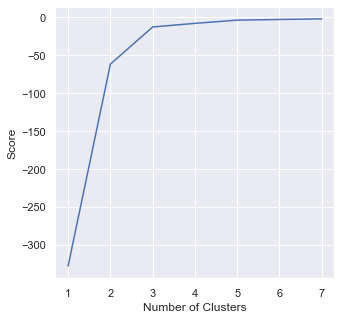

In [529]:
K_clusters = range(1,8)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = p_route[['latitude']]
X_axis = p_route[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

In [530]:
kmeans = KMeans(n_clusters = 5, init ='k-means++')
kmeans.fit(clus[clus.columns[1:3]])
clus['cluster_label'] = kmeans.fit_predict(clus[clus.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(clus[clus.columns[1:3]])

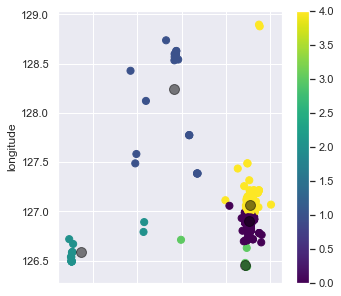

In [531]:
clus.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)

# Affected places in world map by all patients' moving

# Patients move much near Seoul than Daegu

In [532]:
import folium
southkorea_map = folium.Map(location=[36.55,126.983333 ], zoom_start=7,tiles='Stamen Toner')

for lat, lon,city in zip(p_route['latitude'], p_route['longitude'], p_route['city']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        color='red',
                      popup =('City: ' + str(city) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(southkorea_map)
southkorea_map

# 2. Overseas inflow patients' routes

# Chinese overseas inflow routes

In [533]:
clus=china_inflow_route.loc[:,['patient_id','latitude','longitude']]
clus.head(10)

patient_id   latitude   longitude
17   1000000011  37.568369  126.977790
18   1000000011  37.567241  127.005659
120  1000000039  36.992108  127.112945
121  1000000039  37.496318  127.123435
122  1000000039  37.083012  127.056559
123  1000000039  37.496318  127.123435
124  1000000039  37.754825  126.779723

In [534]:
import folium
southkorea_map = folium.Map(location=[36.55,126.983333 ], zoom_start=7,tiles='Stamen Toner')

for lat, lon,city in zip(china_inflow_route['latitude'], china_inflow_route['longitude'], china_inflow_route['city']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        color='red',
                      popup =('City: ' + str(city) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(southkorea_map)
southkorea_map

# Korean overseas inflow routes

In [535]:
clus=korea_inflow_route.loc[:,['patient_id','latitude','longitude']]
clus.head(10)

patient_id   latitude   longitude
0   1000000002  37.563992  127.029534
1   1000000002  37.592057  127.018898
2   1000000002  37.591669  127.018420
3   1000000002  37.606498  127.092761
4   1000000002  37.612772  127.098167
7   1000000004  37.612772  127.098167
11  1000000009  37.514544  127.106597
12  1000000009  37.498450  127.107250
13  1000000009  37.612772  127.098167
68  1000000027  37.612772  127.098167

In [536]:
import folium
southkorea_map = folium.Map(location=[36.55,126.983333 ], zoom_start=7,tiles='Stamen Toner')

for lat, lon,city in zip(korea_inflow_route['latitude'], korea_inflow_route['longitude'], korea_inflow_route['city']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        color='red',
                      popup =('City: ' + str(city) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(southkorea_map)
southkorea_map

# 3. Shincheonji church patients' routes

In [537]:
clus=SCJChurch_route.loc[:,['patient_id','latitude','longitude']]
clus.head(10)

patient_id   latitude   longitude
56   1000000023  35.841206  128.598243
57   1000000023  37.477840  126.987315
58   1000000023  37.435023  126.991583
59   1000000023  37.488337  127.028614
156  1000000047  35.871435  128.601445
157  1000000047  37.513530  127.031534
158  1000000047  37.486472  127.012918
159  1000000047  37.510275  127.043817
160  1000000047  37.561128  127.035505
161  1000000047  37.567014  126.997830

# SCJ Church did not cooperate with the investigation center, so no much patient data and patient_route data.
# But they seem like moved in Daegu and GSBD where the most patients come from.

In [538]:
import folium
southkorea_map = folium.Map(location=[36.55,126.983333 ], zoom_start=7,tiles='Stamen Toner')

for lat, lon,city in zip(SCJChurch_route['latitude'], SCJChurch_route['longitude'], SCJChurch_route['city']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        color='red',
                      popup =('City: ' + str(city) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(southkorea_map)
southkorea_map

# 4. Patients infected by contact routes

In [539]:
clus=contactP_route.loc[:,['patient_id','latitude','longitude']]
clus.head(10)

patient_id   latitude   longitude
5   1000000003  37.586288  126.999716
6   1000000003  37.578708  126.997551
8   1000000005  37.612772  127.098167
9   1000000006  37.578708  126.997551
10  1000000007  37.578708  126.997551
14  1000000010  37.586288  126.999716
15  1000000010  37.602643  127.039518
16  1000000010  37.578708  126.997551
19  1000000013  37.587013  127.026884
20  1000000013  37.575646  127.015410

In [540]:
import folium
southkorea_map = folium.Map(location=[36.55,126.983333 ], zoom_start=7,tiles='Stamen Toner')

for lat, lon,city in zip(contactP_route['latitude'], contactP_route['longitude'], contactP_route['city']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        color='red',
                      popup =('City: ' + str(city) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(southkorea_map)
southkorea_map

# except patients infected by the SCJ Church, the most patients move nearby Seoul and the big cities

# D. Time from confirmation to release or death

In [541]:
p_info.head()

patient_id  global_num     sex  birth_year  age country province  \
0  1000000001         2.0    male      1964.0  50s   Korea    Seoul   
1  1000000002         5.0    male      1987.0  30s   Korea    Seoul   
2  1000000003         6.0    male      1964.0  50s   Korea    Seoul   
3  1000000004         7.0    male      1991.0  20s   Korea    Seoul   
4  1000000005         9.0  female      1992.0  20s   Korea    Seoul   

          city disease        infection_case  infection_order   infected_by  \
0   Gangseo-gu     NaN       overseas inflow              1.0           NaN   
1  Jungnang-gu     NaN       overseas inflow              1.0           NaN   
2    Jongno-gu     NaN  contact with patient              2.0  2.002000e+09   
3      Mapo-gu     NaN       overseas inflow              1.0           NaN   
4  Seongbuk-gu     NaN  contact with patient              2.0  1.000000e+09   

   contact_number symptom_onset_date confirmed_date released_date  \
0            75.0         2020-01-22     2020-01-23    2020-02-05   
1            31.0                NaN     2020-01-30    2020-03-02   
2            17.0                NaN     2020-01-30    2020-02-19   
3             9.0         2020-01-26     2020-01-30    2020-02-15   
4             2.0                NaN     2020-01-31    2020-02-24   

  deceased_date     state  
0           NaN  released  
1           NaN  released  
2           NaN  released  
3           NaN  released  
4           NaN  released

In [542]:
date_cols = ["confirmed_date", "released_date", "deceased_date"]
for col in date_cols:
    p_info[col] = pd.to_datetime(p_info[col])

In [543]:
p_info["time_to_release_since_confirmed"] = p_info["released_date"] - p_info["confirmed_date"]

p_info["time_to_death_since_confirmed"] = p_info["deceased_date"] - p_info["confirmed_date"]
p_info["duration_since_confirmed"] = p_info[["time_to_release_since_confirmed", "time_to_death_since_confirmed"]].min(axis=1)
p_info["duration_days"] = p_info["duration_since_confirmed"].dt.days
p_info["state_by_gender"] = p_info["state"] + "_" + p_info["sex"]

In [544]:
p_info.head()

patient_id  global_num     sex  birth_year  age country province  \
0  1000000001         2.0    male      1964.0  50s   Korea    Seoul   
1  1000000002         5.0    male      1987.0  30s   Korea    Seoul   
2  1000000003         6.0    male      1964.0  50s   Korea    Seoul   
3  1000000004         7.0    male      1991.0  20s   Korea    Seoul   
4  1000000005         9.0  female      1992.0  20s   Korea    Seoul   

          city disease        infection_case  ...  symptom_onset_date  \
0   Gangseo-gu     NaN       overseas inflow  ...          2020-01-22   
1  Jungnang-gu     NaN       overseas inflow  ...                 NaN   
2    Jongno-gu     NaN  contact with patient  ...                 NaN   
3      Mapo-gu     NaN       overseas inflow  ...          2020-01-26   
4  Seongbuk-gu     NaN  contact with patient  ...                 NaN   

   confirmed_date  released_date deceased_date     state  \
0      2020-01-23     2020-02-05           NaT  released   
1      2020-01-30     2020-03-02           NaT  released   
2      2020-01-30     2020-02-19           NaT  released   
3      2020-01-30     2020-02-15           NaT  released   
4      2020-01-31     2020-02-24           NaT  released   

  time_to_release_since_confirmed time_to_death_since_confirmed  \
0                         13 days                           NaT   
1                         32 days                           NaT   
2                         20 days                           NaT   
3                         16 days                           NaT   
4                         24 days                           NaT   

  duration_since_confirmed duration_days  state_by_gender  
0                  13 days          13.0    released_male  
1                  32 days          32.0    released_male  
2                  20 days          20.0    released_male  
3                  16 days          16.0    released_male  
4                  24 days          24.0  released_female  

[5 rows x 23 columns]

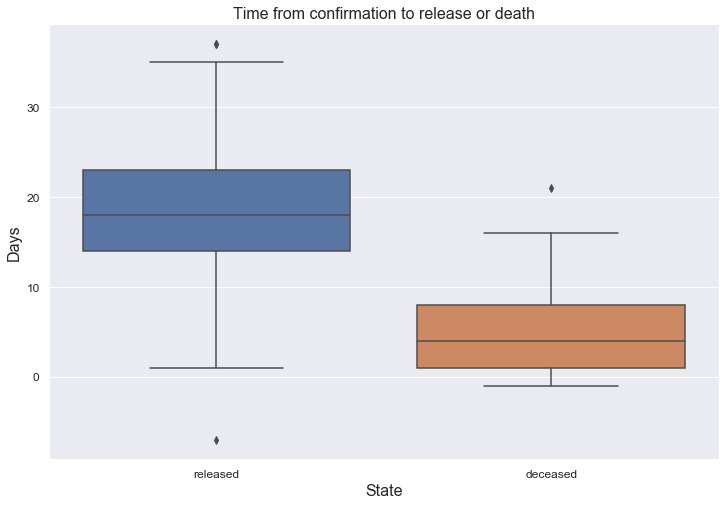

In [545]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="state",
            y="duration_days",
            order=["released", "deceased"],
            data=p_info)
plt.title("Time from confirmation to release or death", fontsize=16)
plt.xlabel("State", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

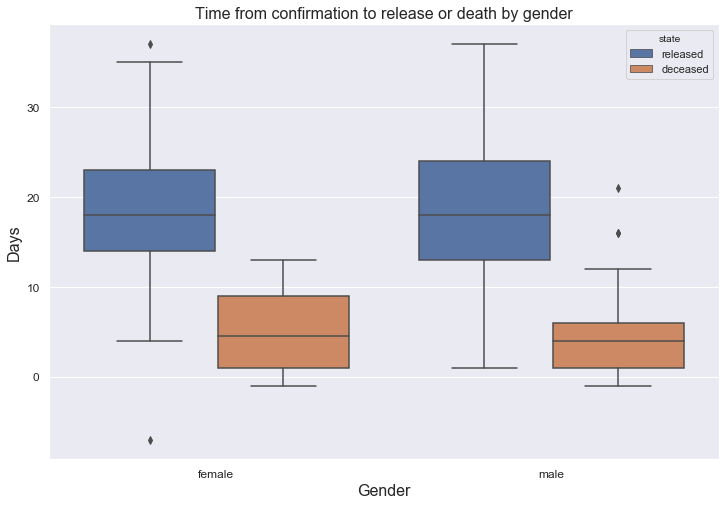

In [546]:
order_duration_sex = ["female", "male"]
plt.figure(figsize=(12, 8))
sns.boxplot(x="sex",
            y="duration_days",
            order=order_duration_sex,
            hue="state",            
            hue_order=["released", "deceased"],
            data=p_info)
plt.title("Time from confirmation to release or death by gender",
          fontsize=16)
plt.xlabel("Gender", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

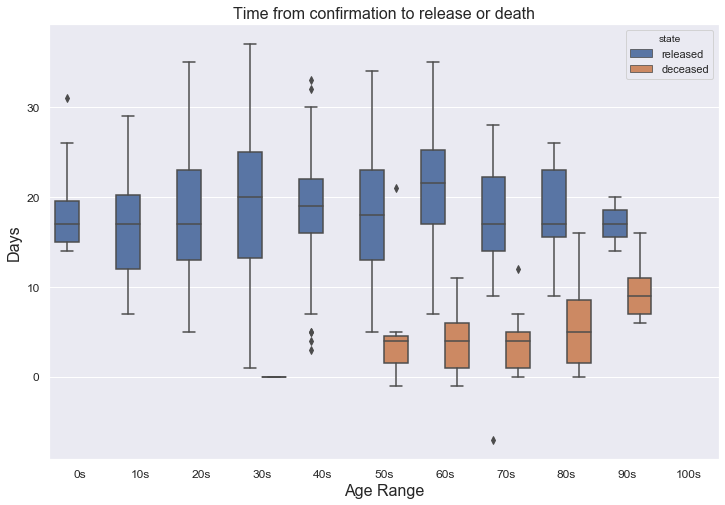

In [547]:
ageList = ['0s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100s']
plt.figure(figsize=(12, 8))
sns.boxplot(x="age",
            y="duration_days",
            order=ageList,
            hue="state",
            hue_order=["released", "deceased"],
            data=p_info)
plt.title("Time from confirmation to release or death", fontsize=16)
plt.xlabel("Age Range", fontsize=16)
plt.ylabel("Days", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Released patients have been released in 25 days.
# Deceased patients have been dead in 10 days.

# E. the number of tests

In [548]:
timeGraph = time.set_index('date')

In [549]:
timeTemp = timeGraph[['confirmed', 'released', 'deceased']]

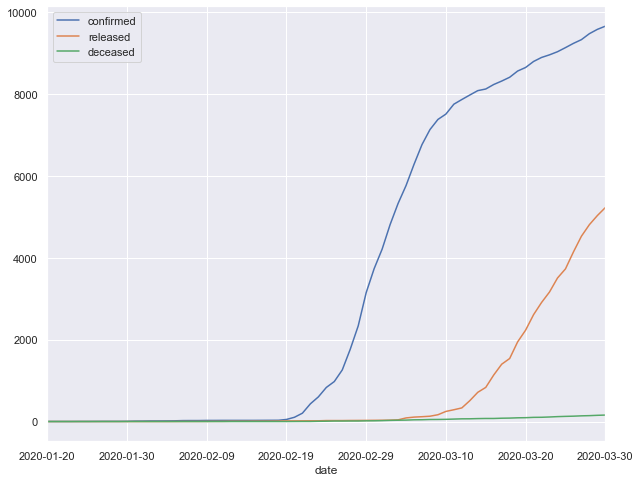

In [550]:
timeTemp.plot(figsize=(10,8))

In [551]:
confirm_perc=(time['confirmed'].sum()/(time['test'].sum()))*100
released_perc=(time['released'].sum()/(time['test'].sum()))*100
deceased_perc=(time['deceased'].sum()/(time['test'].sum()))*100

In [552]:
print("The percentage of confirm  is "+ str(confirm_perc) )
print("The percentage of released is "+ str(released_perc) )
print("The percentage of deceased is "+ str(deceased_perc) )

The percentage of confirm  is 2.9114111886036502
The percentage of released is 0.6162932185784241
The percentage of deceased is 0.029844190532719986


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


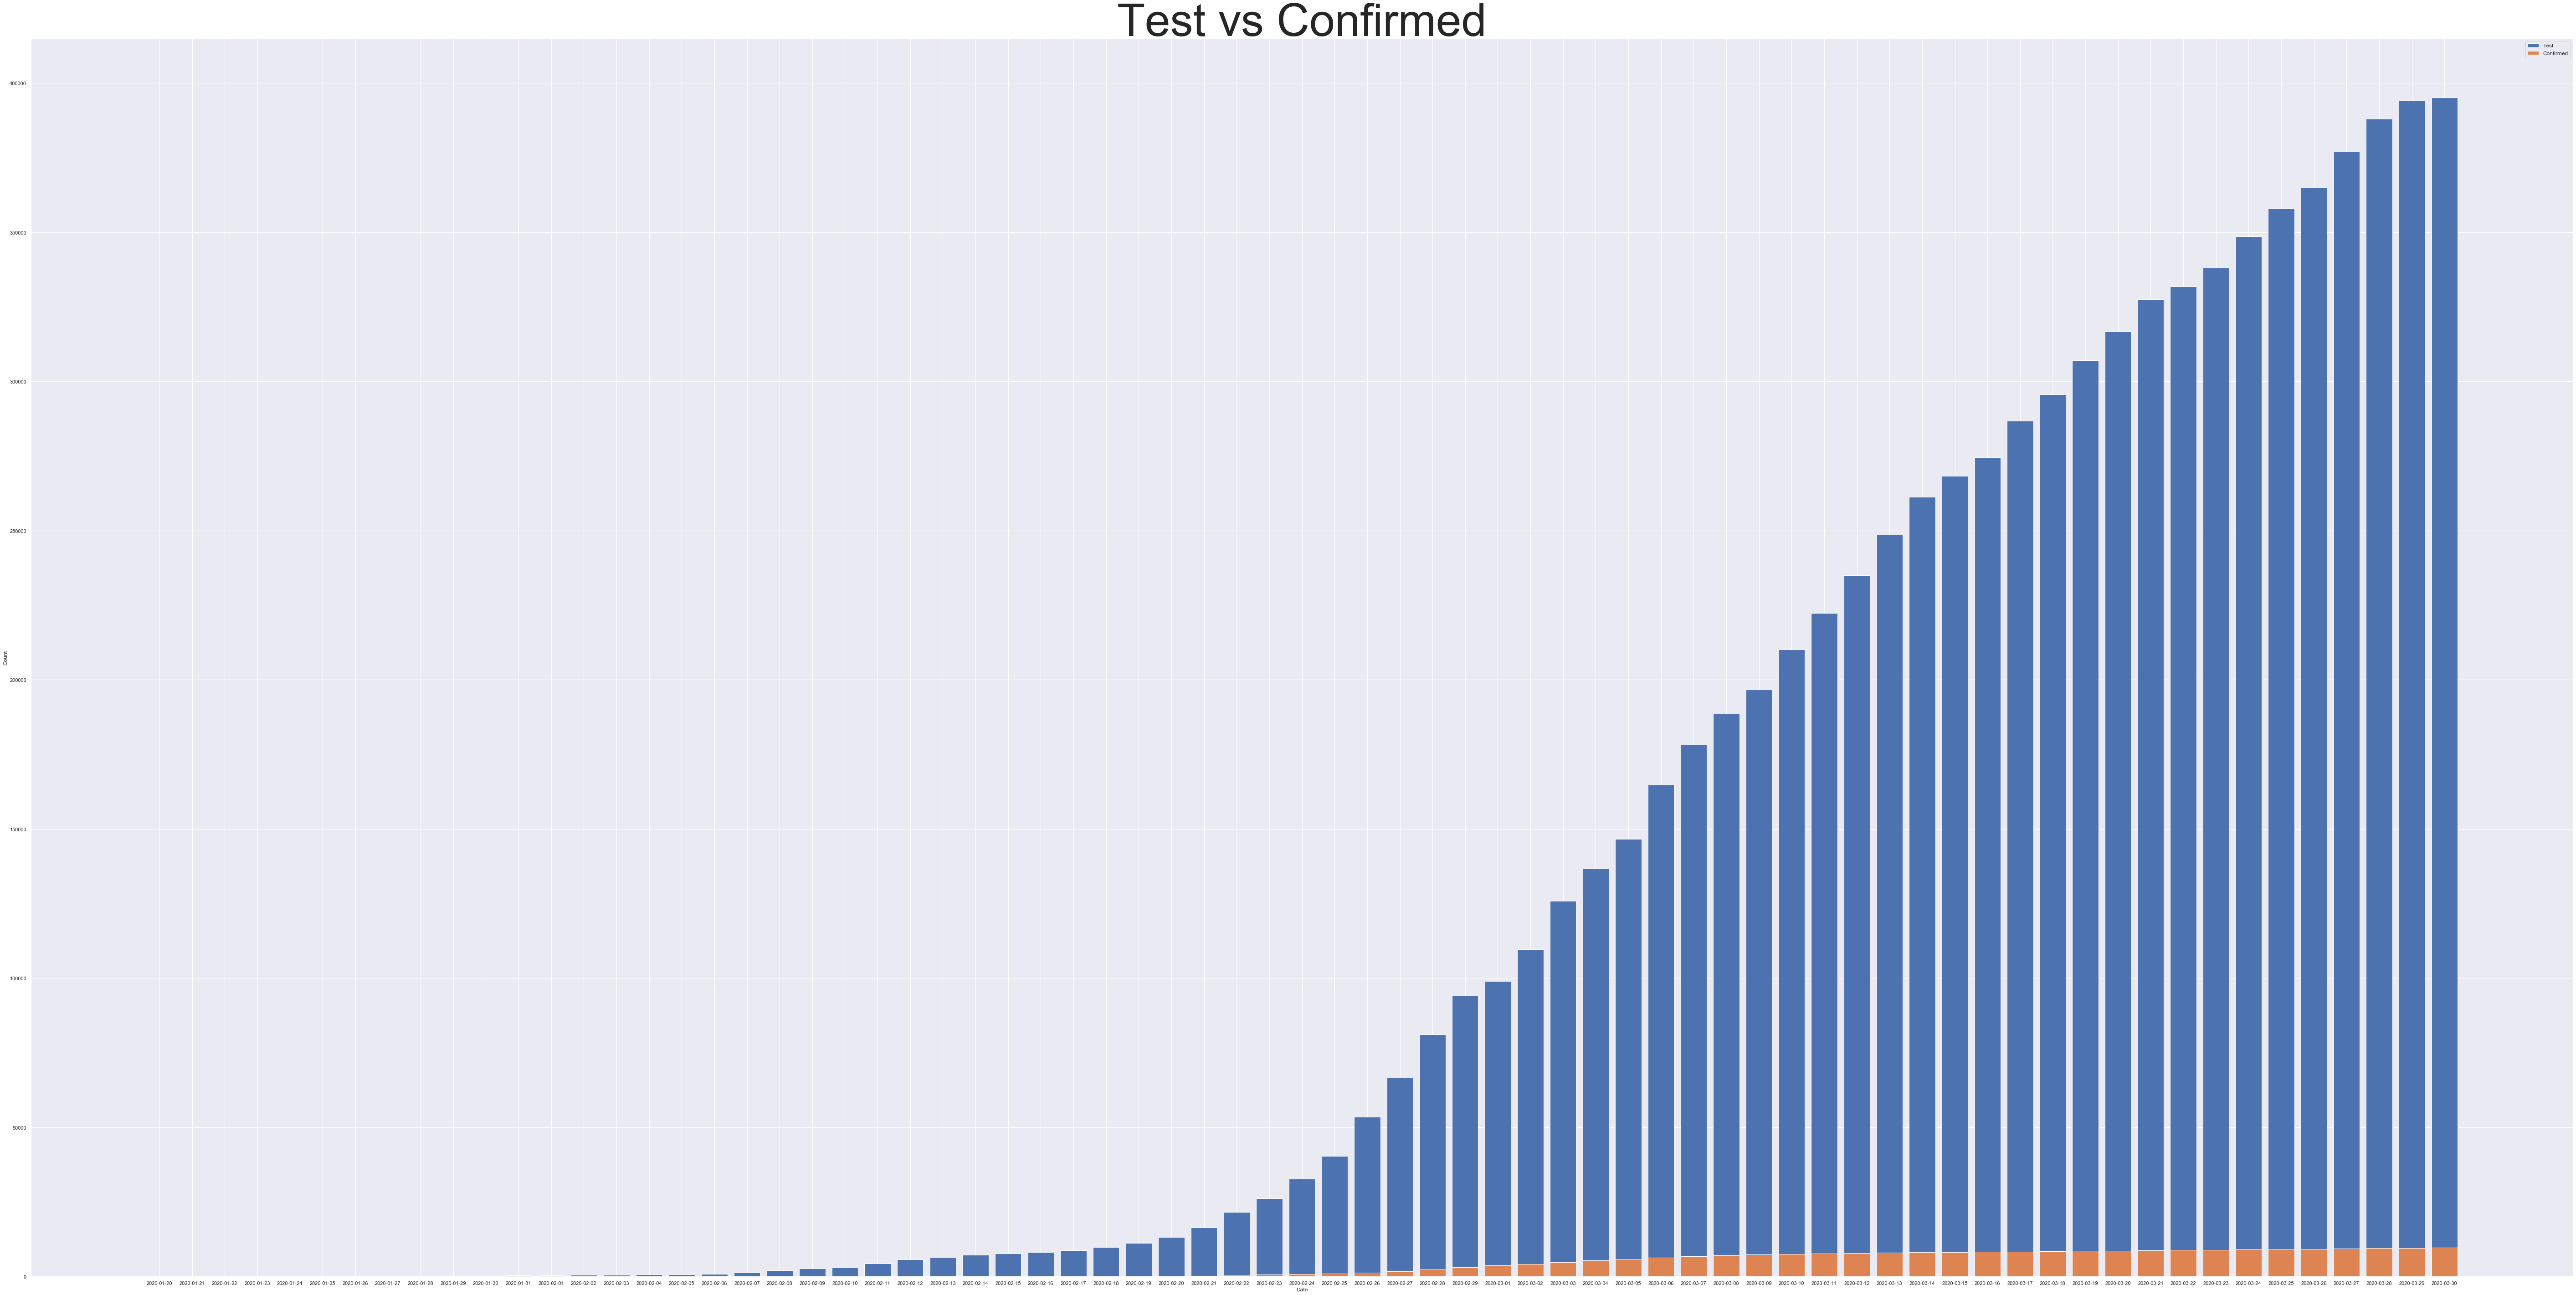

In [553]:
plt.figure(figsize=(100,50))
plt.bar(time.date, time.test,label="Test")
plt.bar(time.date, time.confirmed, label = "Confirmed")
plt.xlabel('Date')
plt.ylabel("Count")
plt.title('Test vs Confirmed',fontsize=100)
plt.legend(frameon=True, fontsize=12)
plt.show()

# 1. time age

In [554]:
t_ageGraph = t_age.set_index('date')

In [555]:
t_ageGraph = t_ageGraph[['age', 'confirmed', 'deceased']]

In [556]:
t_ageGraph.head()

age  confirmed  deceased
date                                
2020-03-02   0s         32         0
2020-03-02  10s        169         0
2020-03-02  20s       1235         0
2020-03-02  30s        506         1
2020-03-02  40s        633         1

In [557]:
t_0s = t_ageGraph[t_ageGraph['age'] == '0s'][['confirmed', 'deceased']]
t_10s = t_ageGraph[t_ageGraph['age'] == '10s'][['confirmed', 'deceased']]
t_20s = t_ageGraph[t_ageGraph['age'] == '20s'][['confirmed', 'deceased']]
t_30s = t_ageGraph[t_ageGraph['age'] == '30s'][['confirmed', 'deceased']]
t_40s = t_ageGraph[t_ageGraph['age'] == '40s'][['confirmed', 'deceased']]
t_50s = t_ageGraph[t_ageGraph['age'] == '50s'][['confirmed', 'deceased']]
t_60s = t_ageGraph[t_ageGraph['age'] == '60s'][['confirmed', 'deceased']]
t_70s = t_ageGraph[t_ageGraph['age'] == '70s'][['confirmed', 'deceased']]
t_80s = t_ageGraph[t_ageGraph['age'] == '80s'][['confirmed', 'deceased']]

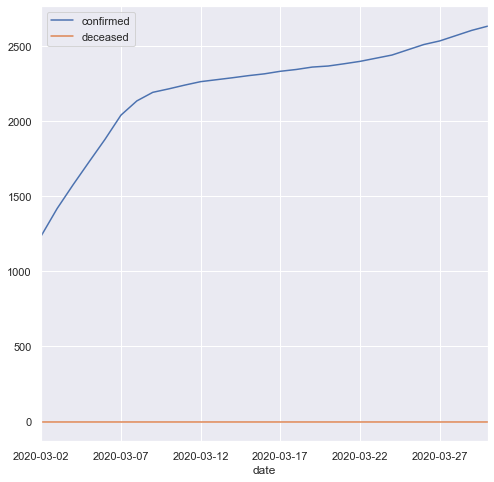

In [558]:
t_20s.plot(figsize=(8,8))

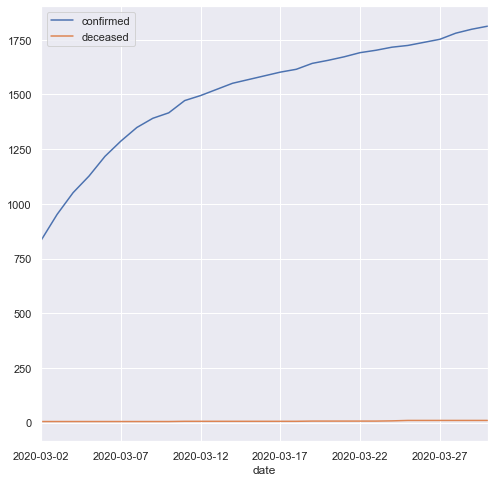

In [559]:
t_50s.plot(figsize=(8,8))

In [560]:
t_age = t_age[t_age['date'] == '2020-03-22']

In [561]:
t_age['confirmed'].sum()

8897

In [562]:
ageList = ['0s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s']
ageConfirmed = pd.DataFrame(index=ageList, columns=['total_confirmed'])
ageDeceased = pd.DataFrame(index=ageList, columns=['total_deceased'])

for i in range(len(ageList)):
    ageConfirmed.loc[ageList[i]]['total_confirmed'] = t_age[t_age['age'] == ageList[i]]['confirmed'].sum()
    ageDeceased.loc[ageList[i]]['total_deceased'] = t_age[t_age['age'] == ageList[i]]['deceased'].sum()
    
ageConfirmed = ageConfirmed.sort_values(by='total_confirmed', ascending=True)
ageDeceased = ageDeceased.sort_values(by='total_deceased', ascending=True)

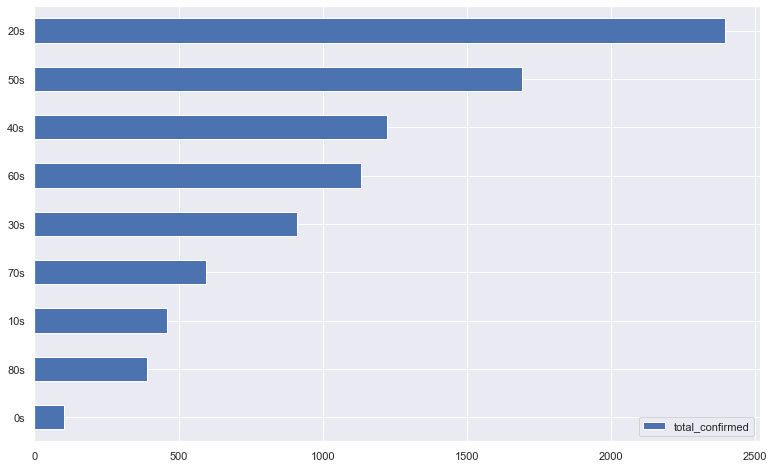

In [563]:
ax = ageConfirmed.plot.barh(figsize=(13,8))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text yticklabel objects>)

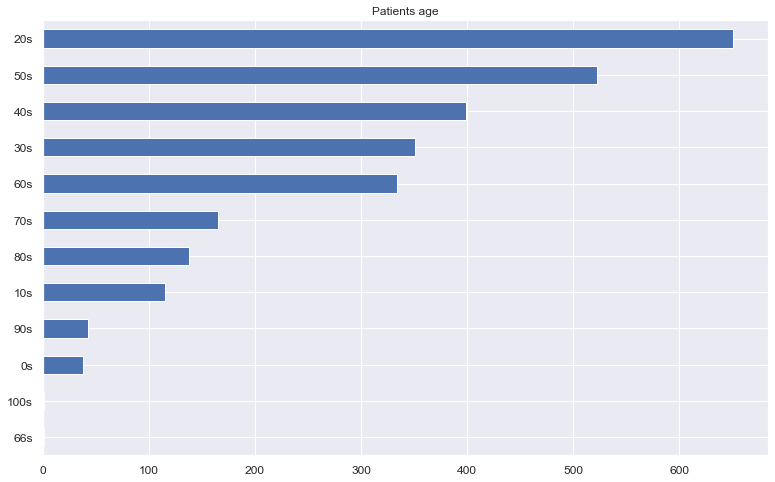

In [564]:
plt.figure(figsize=(13, 8))
plt.title('Patients age')
p_info.age.value_counts(ascending=True).plot.barh()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 20s, 50s, 40s are the most.

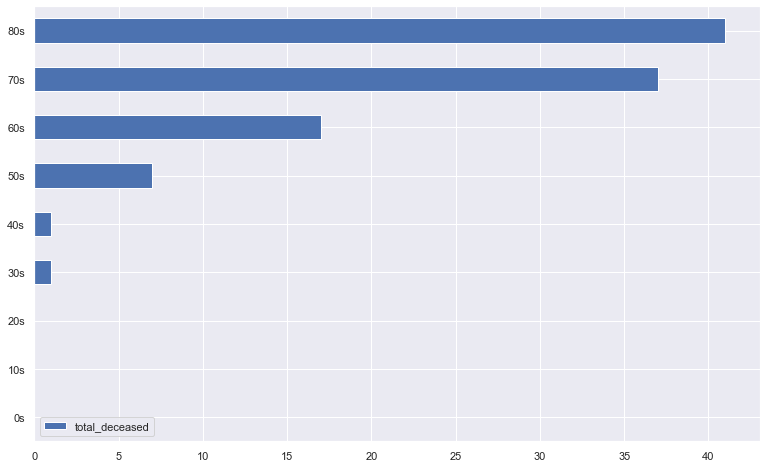

In [565]:
ax = ageDeceased.plot.barh(figsize=(13,8))

# As we expect, the older the more deceased patients.

# 2. time gender

In [566]:
t_genderGraph = t_gender.set_index('date')

In [567]:
t_genderGraph.head()

time     sex  confirmed  deceased
date                                         
2020-03-02     0    male       1591        13
2020-03-02     0  female       2621         9
2020-03-03     0    male       1810        16
2020-03-03     0  female       3002        12
2020-03-04     0    male       1996        20

In [568]:
t_male = t_genderGraph[t_genderGraph['sex'] == 'male'][['confirmed', 'deceased']]
t_female = t_genderGraph[t_genderGraph['sex'] == 'female'][['confirmed', 'deceased']]

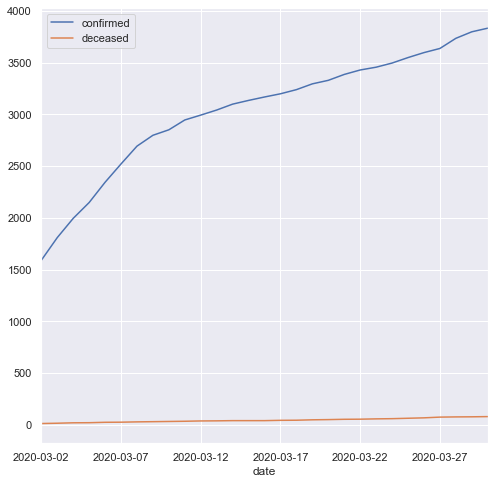

In [569]:
t_male.plot(figsize=(8,8))

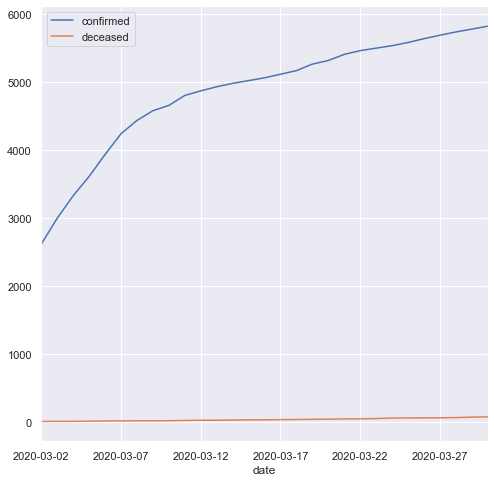

In [570]:
t_female.plot(figsize=(8,8))

In [571]:
t_gender = t_gender[t_gender['date'] == '2020-03-22']

In [572]:
index = t_gender['sex'].unique()
sexConfirmed = pd.DataFrame(index=index, columns=['total_confirmed'])
sexDeceased = pd.DataFrame(index=index, columns=['total_deceased'])

for i in range(2):
    sexConfirmed.loc[index[i]]['total_confirmed'] = t_gender[t_gender['sex'] == index[i]]['confirmed'].sum()
    sexDeceased.loc[index[i]]['total_deceased'] = t_gender[t_gender['sex'] == index[i]]['deceased'].sum()
    

In [573]:
sexConfirmed

total_confirmed
male              3430
female            5467

In [574]:
sexDeceased

total_deceased
male               55
female             49

Text(0.5, 1.0, 'Male vs. Female')

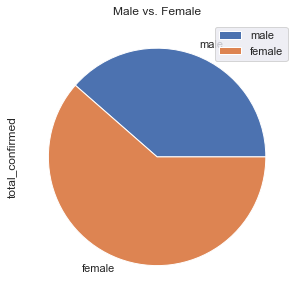

In [575]:
sexConfirmed.plot.pie(y='total_confirmed', figsize=(5, 5))
plt.title("Male vs. Female")

Text(0.5, 1.0, 'Male vs. Female')

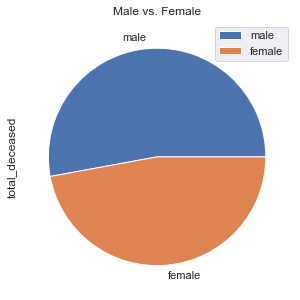

In [576]:
sexDeceased.plot.pie(y='total_deceased', figsize=(5, 5))
plt.title("Male vs. Female")

# 3. time province

In [577]:
t_provin = t_provin[t_provin['date'] == '2020-03-22']
t_provin = t_provin.reset_index(drop=True)

In [578]:
t_provin

date  time           province  confirmed  released  deceased
0   2020-03-22     0              Seoul        324        64         0
1   2020-03-22     0              Busan        108        69         1
2   2020-03-22     0              Daegu       6387      2107        75
3   2020-03-22     0            Incheon         40         8         0
4   2020-03-22     0            Gwangju         19        10         0
5   2020-03-22     0            Daejeon         24         6         0
6   2020-03-22     0              Ulsan         36        12         0
7   2020-03-22     0             Sejong         41         3         0
8   2020-03-22     0        Gyeonggi-do        337        82         3
9   2020-03-22     0         Gangwon-do         30        13         1
10  2020-03-22     0  Chungcheongbuk-do         35         9         0
11  2020-03-22     0  Chungcheongnam-do        120        39         0
12  2020-03-22     0       Jeollabuk-do         10         7         0
13  2020-03-22     0       Jeollanam-do          6         3         0
14  2020-03-22     0   Gyeongsangbuk-do       1254       432        24
15  2020-03-22     0   Gyeongsangnam-do         88        42         0
16  2020-03-22     0            Jeju-do          4         3         0

In [579]:
provinceList = t_provin['province'].unique()

In [580]:
totalCProvince = pd.DataFrame(index=t_provin['province'].unique(), columns=['total_confirmed'])
totalDProvince = pd.DataFrame(index=t_provin['province'].unique(), columns=['total_deceased'])
totalRProvince = pd.DataFrame(index=t_provin['province'].unique(), columns=['total_released'])

In [581]:
for i in range(len(provinceList)):
    totalCProvince.loc[provinceList[i]]['total_confirmed'] = t_provin[t_provin['province'] == provinceList[i]]['confirmed'].sum()
    totalDProvince.loc[provinceList[i]]['total_deceased'] = t_provin[t_provin['province'] == provinceList[i]]['deceased'].sum()
    totalRProvince.loc[provinceList[i]]['total_released'] = t_provin[t_provin['province'] == provinceList[i]]['released'].sum()
    

In [582]:
totalCProvince

total_confirmed
Seoul                         324
Busan                         108
Daegu                        6387
Incheon                        40
Gwangju                        19
Daejeon                        24
Ulsan                          36
Sejong                         41
Gyeonggi-do                   337
Gangwon-do                     30
Chungcheongbuk-do              35
Chungcheongnam-do             120
Jeollabuk-do                   10
Jeollanam-do                    6
Gyeongsangbuk-do             1254
Gyeongsangnam-do               88
Jeju-do                         4

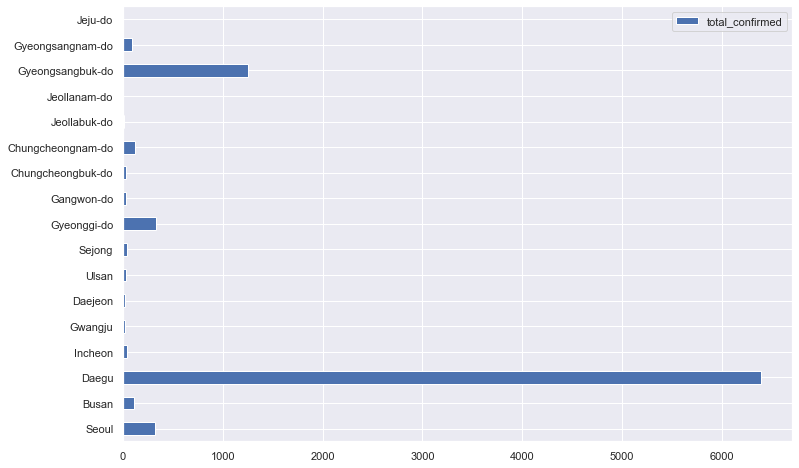

In [583]:
ax = totalCProvince.plot.barh(figsize=(12,8))

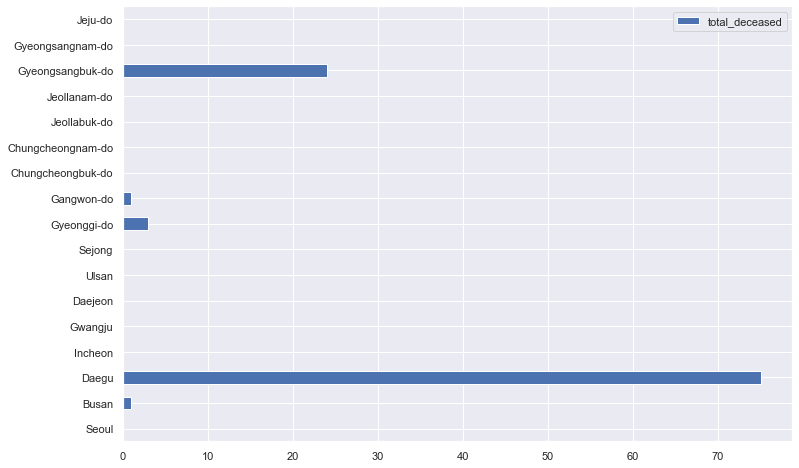

In [584]:
ax = totalDProvince.plot.barh(figsize=(12,8))

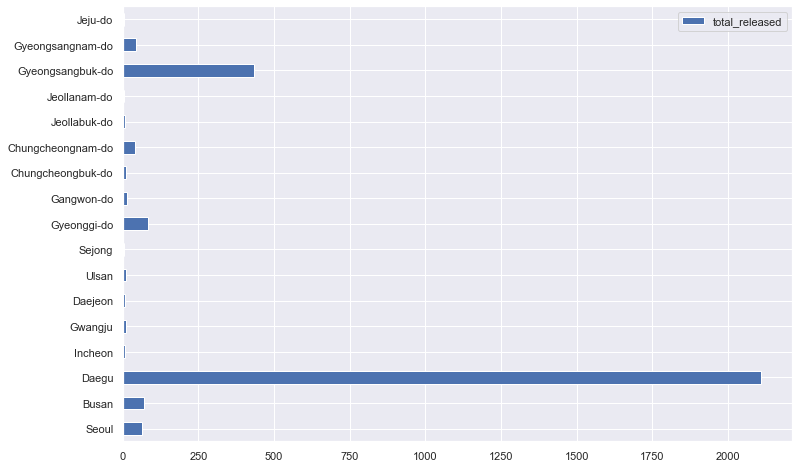

In [585]:
ax = totalRProvince.plot.barh(figsize=(12,8))

# There are the most patients in Daegu and GSBD, so the number of released, deceased, confirmed is the largest.

# F. weather data

In [586]:
weather.head()

code province        date  avg_temp  min_temp  max_temp  precipitation  \
0  10000    Seoul  2016-01-01       1.2      -3.3       4.0            NaN   
1  11000    Busan  2016-01-01       5.3       1.1      10.9            NaN   
2  12000    Daegu  2016-01-01       1.7      -4.0       8.0            NaN   
3  13000  Gwangju  2016-01-01       3.2      -1.5       8.1            NaN   
4  14000  Incheon  2016-01-01       3.1      -0.4       5.7            NaN   

   max_wind_speed  most_wind_direction  avg_relative_humidity  
0             3.5                 90.0                   73.0  
1             7.4                340.0                   52.1  
2             3.7                270.0                   70.5  
3             2.7                230.0                   73.1  
4             5.3                180.0                   83.9

In [587]:
weatherTemp = weather.groupby(['date']).mean()

In [588]:
weatherTemp = weatherTemp[['avg_temp', 'precipitation', 'max_wind_speed', 'avg_relative_humidity']]

In [589]:
weatherTemp.head()

avg_temp  precipitation  max_wind_speed  avg_relative_humidity
date                                                                      
2016-01-01   3.11875            NaN         4.61250               66.11250
2016-01-02   6.67500          0.000         4.73125               70.92500
2016-01-03   7.56875            NaN         3.66250               77.26875
2016-01-04   6.25625            NaN         5.28750               56.38750
2016-01-05   1.71250          2.625         4.90000               41.88750

# Mining data with weather data

In [590]:
timeTemp = time[['date', 'confirmed']]
timeTemp = timeTemp.set_index('date')

In [591]:
weather_confirmed = pd.merge(timeTemp, weatherTemp, on='date')
weather_confirmed = weather_confirmed.reindex(columns = ['avg_temp', 'precipitation', 'max_wind_speed', 'avg_relative_humidity', 'confirmed'])
weather_confirmed.tail()

avg_temp  precipitation  max_wind_speed  avg_relative_humidity  \
date                                                                         
2020-03-25  12.51250       0.000000         4.44375               55.85000   
2020-03-26  14.31875       9.053333         4.25625               75.50625   
2020-03-27  11.86250       5.481250         6.46875               82.08125   
2020-03-28   7.81250       2.150000         5.66875               49.50000   
2020-03-29   8.48750       0.100000         5.08125               58.66875   

            confirmed  
date                   
2020-03-25       9137  
2020-03-26       9241  
2020-03-27       9332  
2020-03-28       9478  
2020-03-29       9583

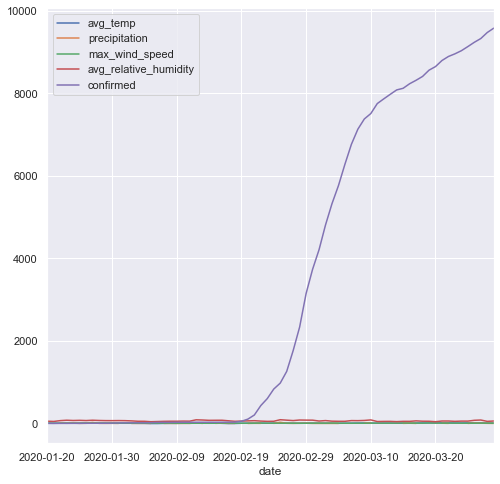

In [592]:
weather_confirmed.plot(figsize=(8,8))

# There is no big relationship between weather and the virus.

# E. Prediction of confirmed number

# 1. Facebook prophet model

In [593]:
df_korea = time[['date', 'confirmed']]

In [594]:
df_korea.tail()

date  confirmed
66  2020-03-26       9241
67  2020-03-27       9332
68  2020-03-28       9478
69  2020-03-29       9583
70  2020-03-30       9661

In [595]:
# Make dataframe for Facebook Prophet prediction model
df_prophet = df_korea.rename(columns={
    'date': 'ds',
    'confirmed': 'y'
})

df_prophet.tail()

ds     y
66  2020-03-26  9241
67  2020-03-27  9332
68  2020-03-28  9478
69  2020-03-29  9583
70  2020-03-30  9661

In [596]:
m = Prophet(
    changepoint_prior_scale=0.2, # increasing it will make the trend more flexible
    changepoint_range=0.98, # place potential changepoints in the first 98% of the time series
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    seasonality_mode='additive'
)
m.fit(df_prophet)

In [597]:
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)
forecast.tail(7)

ds         trend   yhat_lower    yhat_upper  trend_lower  \
71 2020-03-31   9768.287904  9719.964087   9816.909013  9760.784493   
72 2020-04-01   9869.803643  9803.748486   9938.974382  9834.913632   
73 2020-04-02   9971.319382  9875.382843  10091.995688  9883.145287   
74 2020-04-03  10072.835121  9904.622416  10269.298223  9922.888087   
75 2020-04-04  10174.350861  9943.009235  10443.382517  9952.243027   
76 2020-04-05  10275.866600  9946.790390  10637.265953  9946.066950   
77 2020-04-06  10377.382339  9937.424097  10858.068046  9938.038096   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
71   9774.045057       -2.714922             -2.714922             -2.714922   
72   9919.283204       -2.714922             -2.714922             -2.714922   
73  10087.628448       -2.714922             -2.714922             -2.714922   
74  10257.908015       -2.714922             -2.714922             -2.714922   
75  10444.237454       -2.714922             -2.714922             -2.714922   
76  10634.604836       -2.714922             -2.714922             -2.714922   
77  10851.151418       -2.714922             -2.714922             -2.714922   

       daily  daily_lower  daily_upper  multiplicative_terms  \
71 -2.714922    -2.714922    -2.714922                   0.0   
72 -2.714922    -2.714922    -2.714922                   0.0   
73 -2.714922    -2.714922    -2.714922                   0.0   
74 -2.714922    -2.714922    -2.714922                   0.0   
75 -2.714922    -2.714922    -2.714922                   0.0   
76 -2.714922    -2.714922    -2.714922                   0.0   
77 -2.714922    -2.714922    -2.714922                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper          yhat  
71                         0.0                         0.0   9765.572981  
72                         0.0                         0.0   9867.088720  
73                         0.0                         0.0   9968.604460  
74                         0.0                         0.0  10070.120199  
75                         0.0                         0.0  10171.635938  
76                         0.0                         0.0  10273.151677  
77                         0.0                         0.0  10374.667417

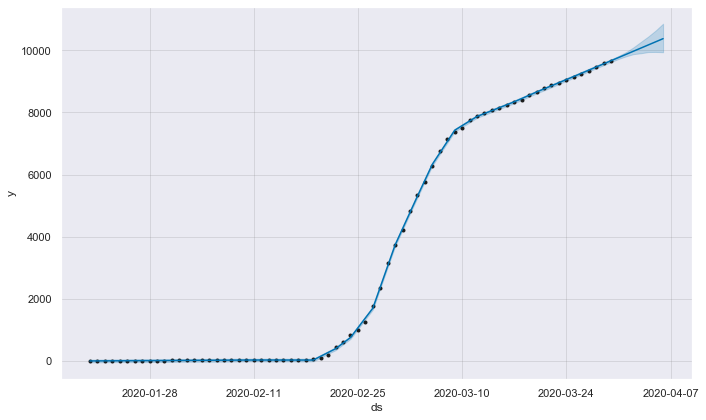

In [598]:
fig = m.plot(forecast)

# 2. Regression model

In [599]:
df_korea = time[['date', 'confirmed']]
df_korea = df_korea[20:]
df_korea = df_korea.reset_index(drop=True)

In [600]:
df_korea_reg = df_korea.copy()

In [601]:
df_korea_reg = df_korea_reg.set_index('date')
df_korea_reg = df_korea_reg[20:]

In [602]:
df_korea_reg.index = pd.to_datetime(df_korea_reg.index)

In [603]:
x = np.arange(len(df_korea_reg)).reshape(-1, 1)
y = df_korea_reg.values

In [604]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=[32, 32, 10], max_iter=50000, alpha=0.0005, random_state=26)
_=model.fit(x, y)

/Users/parkchanjin/PycharmProjects/ml-work/venv/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1321: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [605]:
test = np.arange(len(df_korea_reg)+7).reshape(-1, 1)
pred = model.predict(test)
prediction = pred.round().astype(int)
week = [df_korea_reg.index[0] + timedelta(days=i) for i in range(len(prediction))]
dt_idx = pd.DatetimeIndex(week)
predicted_count = pd.Series(prediction, dt_idx)

In [606]:
predicted_count.tail()

2020-04-02     9959
2020-04-03    10059
2020-04-04    10163
2020-04-05    10309
2020-04-06    10485
dtype: int64

In [607]:
pd.plotting.register_matplotlib_converters()

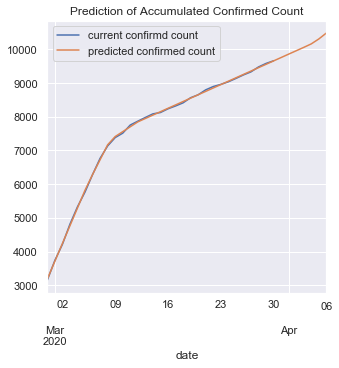

In [608]:
df_korea_reg.plot()
predicted_count.plot()
plt.title('Prediction of Accumulated Confirmed Count')
plt.legend(['current confirmd count', 'predicted confirmed count'])
plt.show()

# 3. Arima(Autoregressive integrated moving avergae)

In [609]:
df_korea.tail()

date  confirmed
46  2020-03-26       9241
47  2020-03-27       9332
48  2020-03-28       9478
49  2020-03-29       9583
50  2020-03-30       9661

In [610]:
model = ARIMA(df_korea['confirmed'].values, order=(1, 2, 1))
fit_model = model.fit(trend='c', full_output=True, disp=True)
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                   49
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -288.008
Method:                       css-mle   S.D. of innovations             86.377
Date:                Tue, 07 Apr 2020   AIC                            584.017
Time:                        20:51:11   BIC                            591.584
Sample:                             2   HQIC                           586.888
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6305     11.522      0.142      0.887     -20.953      24.214
ar.L1.D2.y    -0.0995      0.798     -0.125      0.901      -1.664       1.465
ma.L1.D2.y     0.0252      0.792      0.032      0.975      -1.527       1.578
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -10.0544           +0.0000j           10.0544            0.5000
MA.1          -39.6792           +0.0000j           39.6792            0.5000
-----------------------------------------------------------------------------
"""

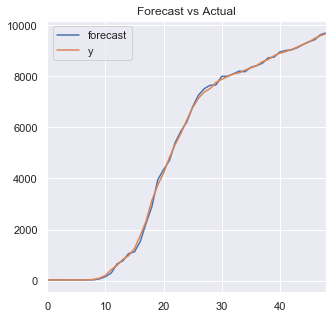

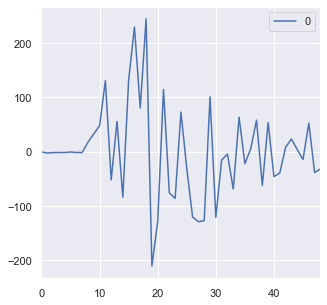

In [611]:
fit_model.plot_predict()
plt.title('Forecast vs Actual')
pd.DataFrame(fit_model.resid).plot()

In [612]:
forcast = fit_model.forecast(steps=7)
pred_y = forcast[0].tolist()
pd.DataFrame(pred_y)

0
0   9742.674231
1   9825.775740
2   9910.528006
3   9996.908801
4  10084.920338
5  10174.562394
6  10265.834994

# 4. LSTM

In [613]:
df_korea_lstm = df_korea_reg.copy()

In [614]:
data = np.array(df_korea_lstm).reshape(-1, 1)
train_data = df_korea_lstm[:len(df_korea_lstm)-5]
test_data = df_korea_lstm[len(df_korea_lstm)-5:]

In [615]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)
n_input = 5
n_features = 1
                             
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (n_input, n_features)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50, return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units = 1))
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
lstm_model.fit(generator, epochs = 21)

Epoch 1/21
21/21 [==============================] - 1s 71ms/step - loss: 0.3705
Epoch 2/21
21/21 [==============================] - 0s 10ms/step - loss: 0.0211
Epoch 3/21
21/21 [==============================] - 0s 11ms/step - loss: 0.0098
Epoch 4/21
21/21 [==============================] - 0s 9ms/step - loss: 0.0107
Epoch 5/21
21/21 [==============================] - 0s 10ms/step - loss: 0.0135
Epoch 6/21
21/21 [==============================] - 0s 10ms/step - loss: 0.0126
Epoch 7/21
21/21 [==============================] - 0s 10ms/step - loss: 0.0078
Epoch 8/21
21/21 [==============================] - 0s 10ms/step - loss: 0.0166
Epoch 9/21
21/21 [==============================] - 0s 10ms/step - loss: 0.0112
Epoch 10/21
21/21 [==============================] - 0s 10ms/step - loss: 0.0104
Epoch 11/21
21/21 [==============================] - 0s 10ms/step - loss: 0.0099
Epoch 12/21
21/21 [==============================] - 0s 11ms/step - loss: 0.0081
Epoch 13/21
21/21 [===================

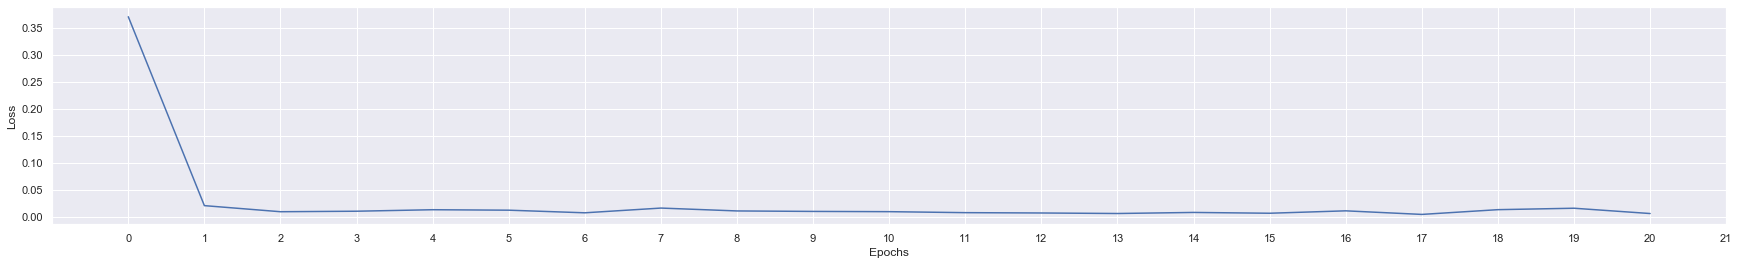

In [616]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize = (30,4))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0,100,1))
plt.plot(range(len(losses_lstm)), losses_lstm)

In [617]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [618]:
prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
prediction.head()

0
0  8685.547044
1  8717.238802
2  8726.955553
3  8714.914976
4  8672.908737

# To sum up!

# Let's compare the graph with the graph except the SCJ church confirmed from Daegu and Gyeongsangbukdo.
# We assume that all patients infected in the SCJ church are come from Daegu and GSBD, where are the heart of the SCJ church. 
# p.s. Shincheonji Church of Jesus is based in Daegu, and GSBD is the closest region from Daegu.

In [619]:
t_provin = pd.read_csv(path+'TimeProvince.csv')

In [620]:
t_provin.head()

date  time province  confirmed  released  deceased
0  2020-01-20    16    Seoul          0         0         0
1  2020-01-20    16    Busan          0         0         0
2  2020-01-20    16    Daegu          0         0         0
3  2020-01-20    16  Incheon          1         0         0
4  2020-01-20    16  Gwangju          0         0         0

In [621]:
t_provinG = t_provin.groupby('date')['confirmed'].sum()
t_provinG = pd.DataFrame(t_provinG)

In [622]:
t_provinG['date'] = t_provinG.index
t_provinG.reset_index(drop=True, inplace=True)
t_provinG = t_provinG.reindex(columns=['date', 'confirmed'])

In [623]:
t_provinG['confirmed'] = t_provinG['confirmed'].diff()

In [624]:
t_provinG.head()

date  confirmed
0  2020-01-20        NaN
1  2020-01-21        0.0
2  2020-01-22        0.0
3  2020-01-23        0.0
4  2020-01-24        1.0

In [625]:
t_provinG.nlargest(3, 'confirmed')

date  confirmed
40  2020-02-29      813.0
43  2020-03-03      600.0
41  2020-03-01      586.0

In [626]:
t_provinG['confirmed'].sum()

9458.0

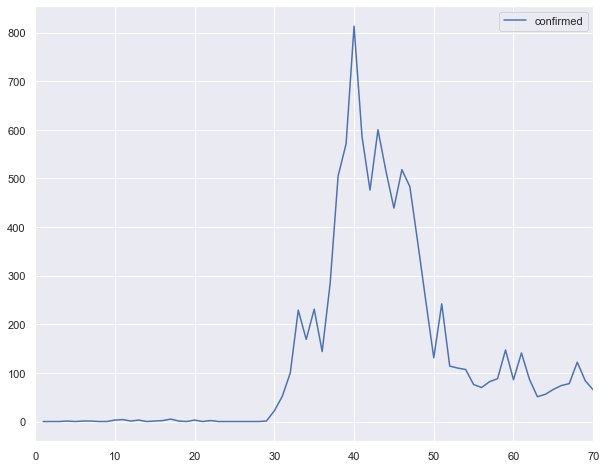

In [627]:
t_provinG.plot(figsize=(10,8))

# Total confirmed number looks like calming down.

In [628]:
i = t_provin[((t_provin.province == 'Daegu') | (t_provin.province == 'Gyeongsangbuk-do'))].index
t_provin_except = t_provin.drop(i)

In [629]:
t_provin_exceptG = t_provin_except.groupby('date')['confirmed'].sum()
t_provin_exceptG = pd.DataFrame(t_provin_exceptG)

In [630]:
t_provin_exceptG['date'] = t_provin_exceptG.index
t_provin_exceptG.reset_index(drop=True, inplace=True)
t_provin_exceptG = t_provin_exceptG.reindex(columns=['date', 'confirmed'])

In [631]:
t_provin_exceptG['confirmed'] = t_provin_exceptG['confirmed'].diff()

In [632]:
t_provin_exceptG.head()

date  confirmed
0  2020-01-20        NaN
1  2020-01-21        0.0
2  2020-01-22        0.0
3  2020-01-23        0.0
4  2020-01-24        1.0

In [633]:
t_provin_exceptG['confirmed'].sum()

1536.0

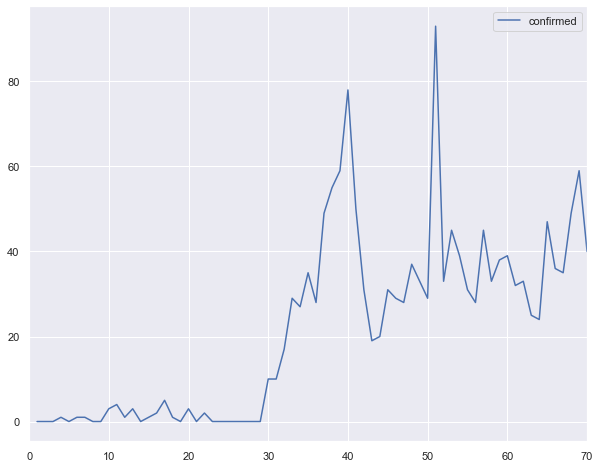

In [634]:
t_provin_exceptG.plot(figsize=(10,8))

# Except Daegu and GSBD, the confirmed graph is upwards, because the overseas inflow is increasing.

These prediction models are not trained with other factors which are related to the virus. We can predict approximate result by refering the past data.

After the simple analysis of the data, we could know how affects of the Shincheonji church were big. Daegu and Gyeongsangbukdo were affected the most by the Shincheonji church. Many Korean experts are saying that the SCJ church distorts the graph of the confirmed number. Except the confirmed patients who were infected by the SCJ church, the graph is upwards because the overseas inflow is increasing. The most percentage of the overseas inflow is Korean living in foreign countries. They might comeback to Korea because of the medical insurance and the developed medical resources. All costs for testing and remedy are free for not only all Koreans but all foreign patients. All costs of testing and remedy are reimbursed by the Korean government for preventing virus from transmission. So many Koreans and experts are worrying about abrupt overseas inflow of foreign people from foreign countries. The experts are warning that a big crisis could come around Seoul and the big cities. Solutions for the increasing overseas inflow to Korea might be needed.